In [43]:
#from code import *
# in later version, functions will be in seperate file...
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import numba
from scipy.ndimage.filters import gaussian_filter1d
import pandas as pd
import scipy.linalg as la


In [114]:
# helper functions, will be put in the "code.py" file in the end

def calc_mod_control(A):
    '''
    Calculate modal controllability for a given adjacency matrix
    '''
    evals, evecs = np.linalg.eig(A)
    modal_c = np.zeros(94)
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            modal_c[i] += (1-evals[j]**2)*evecs[i,j]**2
    return modal_c


def pairmul(v):
    vv = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            vv[i,j]=v[i]*v[j]
    return vv

def calc_ave_control(A):
    '''
    calculate Gramian, average controllability, 
    based on https://complexsystemsupenn.com/s/controllability_code-smb8.zip
    '''
    N = A.shape[0]
    T,Z=la.schur(A)
    midMat= (Z**2).transpose()
    v=np.diag(T)
    vv = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            vv[i,j]=v[i]*v[j]
    P= np.repeat(np.diag(1-vv),N).reshape(N,N)
    average_c=np.sum(midMat/P , axis=0).transpose()
    return average_c


def transition(xs, thres=0.02):
    '''
    Helper function to check if dynamics for a certain parameter 
    configuration passed the transition from low state to oscillatory regime
    '''
    xs = xs[:,-1000:]
    dif = np.max(xs,axis=1)-np.min(xs,axis=1)
    if dif.max()<thres:
        return False
    if dif.max()>thres:
        return True



def load_parameters(singleNode=False, globalN=0, filename_SC='SC_m12av_94_voxNorm_th20.npy', filename_DM='DM_m12av_94_voxNorm.npy'):
    class struct(object):
        pass

    params = struct()
    #FHN parameters with:
    '''
    du/dt = -alpha u^3 + beta u^2 - gamma u - w + I_{ext}
    dw/dt = 1/tau (u + delta  - epsilon w)
    '''
    params.alpha = 3. 
    params.beta = 4. 
    params.gamma = -1.5 
    params.delta = 0.
    params.epsilon = 0.5 
    params.tau = 20. 
    
    ### runtime parameters
    params.dt = 0.1  # simulation timestep in ms 
    params.duration = 3000  # Simulation duration in ms

    ### network parameters
    if singleNode: # if you only want a single node with those parameters
        N = 1
        params.SC = np.zeros((N, N))
        params.DM = np.zeros((N, N))
    elif globalN>0: # if you want a network of N nodes, all uniformly connected
        N = globalN
        SC = np.ones((N,N))
        np.fill_diagonal(SC, 0)
        params.SC = SC
        params.DM = np.zeros((N, N))
    else: # this is what we usually want! Load the netowrk topology from the DTI images
        SC = np.load(filename_SC)
        N = SC.shape[0]          
        params.SC = SC
        params.DM = np.load(filename_DM)
    params.N = N  # number of nodes

    ### global parameters
    params.I = 0.5 # Background input
    params.K = 0.  # global coupling strength
    params.sigma = 0. # Variance of the additive noise
    params.c = 0.  # signal transmission speed
    
    ### Initialization noise
    params.init = (0,1,2,3) #initialize randomly with u in [0,1] & w in [2,3]

    params_dict = params.__dict__
    return params_dict


def timeIntegrationRK4(params, randomseed=0, xinit=np.zeros(94), yinit=np.zeros(94), stimNode=99, stimVal=1, stimOn=1000):
    '''
    Integrate the FHN equations including noise and coupling with RK2 scheme using @numba 
    and return the trajectories for the potential and the recovery variable.
    Equations:
    du_i/dt = - alpha u_i^3 + beta u_i^2 + gamma u_i - w + I + K * SC_ij*u_j(t-c*DM_ij) + sigma*noise 
    dw_i/dt = u_i - delta - epsilon w_i / tau
    
    Args:
        params: Parameter dictionary obtained by load_parameters() + modifications
        Important parameters for the integration are:
            init: (u0min, u0max, w0min, w0max): Limits for randomly drawn initial conditions for every node [mV]
            alpha, beta, gamma: FHN node parameters, determine du/dt
            delta, epsilon, tau: FHN node parameters, determine dw/dt            
            I: Constant background input 
            K: >0, Global coupling strength
            sigma: >0, Variance of the additive noise
            c: >=0, Transmission speed, converts the connection length in DM (DTI data) to a delay, no delay for c=0
            dt: Timestep for simulation [ms]
            duration: Total simulated time [ms]
            globalN:  >=0, Determines number of uniform SC, if 0 use DTI data for connectivity between nodes 
            randomseed: for reproducibility
    ''' 
    # load parameters from dictionary
    N = params['N']
    SC = params['SC']
    DM = params['DM']
    dt = params['dt']
    duration = params['duration']
    I = params['I']
    c = params['c']
    K = params['K']
    sigma = params['sigma']
   
    # FHN parameters
    alpha = params['alpha']
    beta = params['beta']
    gamma = params['gamma']
    delta = params['delta']
    epsilon = params['epsilon']
    tau = params['tau']
    
    # delay matrix:
    if c == 0:
        DM = np.zeros((N, N))
    elif c > 0:
        DM = DM / c / dt # length divided by transmission speed is delay, bring in units of timesteps
    else:
        raise Exception('Parameter c for signal speed must be positive!')
    maxDelay = int(np.max(np.ceil(DM)))
    if (maxDelay)>(duration/dt):
        raise Exception('Simulation time is not long enough for such a low transmission speed, choose higher c or much higher duration')
    # return arrays
    ts = np.arange(0, duration, dt)
    xs = np.zeros((N, len(ts)))
    ys = np.zeros((N, len(ts)))
    
    if randomseed > 0:
        np.random.seed(randomseed)
    if xinit.all() == 0 and randomseed>0:
        xinit = np.random.rand(N)
        yinit = np.random.rand(N)
    x_init = xinit
    y_init = yinit    
    if maxDelay > 0:
        xs[:,:maxDelay] = np.tile(x_init,(maxDelay,1)).T
        ys[:,:maxDelay] = np.tile(y_init,(maxDelay,1)).T
    else:
        xs[:,0] = x_init
        ys[:,0] = y_init
    # prepare noise vector with sigma = 1, factor sqrt_dt to make noise independent of timestep 
    noise = np.random.standard_normal(size=(N, len(ts))) / np.sqrt(dt)

    # actual integration is done with numba for speedup
    ts, xs, ys = timeIntegrationRK4Numba(dt, duration, stimNode, stimVal, stimOn,
                                N, SC, DM, maxDelay,
                                alpha, beta, gamma, delta, epsilon, tau,
                                I, K, sigma, noise,
                                ts, xs, ys)
    return ts, xs, ys, x_init, y_init, maxDelay
@numba.njit(locals = {'idxX': numba.int64, 'idxY':numba.int64, 'idx1':numba.int64, 'idy1':numba.int64})
def timeIntegrationRK4Numba(dt, duration, stimNode, stimVal, stimOn,
                            N, SC, DM, maxDelay,
                            alpha, beta, gamma, delta, epsilon, tau,
                            I, K, sigma, noise, # c is already included in DM
                            ts, xs, ys):
    # load initial values
    x = xs[:,0].copy()
    y = ys[:,0].copy()
    
    for t in range(maxDelay, len(ts)):  # start from max delay here - only consider interesting time steps!
        for n in range(N):             # all nodes
            x_ext = 0  # no y_ext since sum in FHN is only in u term
            for i in range(N):         # get input of every other node
                x_ext = x_ext + SC[i, n] * xs[i, int(np.round(t-DM[i,n]))]  # transmission speed kappa (here: c) already in DM (s.o.)
            # stimulation: 
            if n==stimNode:
                if t>stimOn/dt:
                    stim = stimVal - I # set I_ext to predifined stimulation value for target node
            else: stim = 0.
            # update FHN equations
            x_k1 = - alpha * x[n]**3 + beta * x[n]**2 + gamma * x[n] - y[n] + K * x_ext + sigma * noise[n,t] + I + stim
            y_k1 = (x[n] - delta - epsilon*y[n])/tau
            x_k2 = - alpha * (x[n]+0.5*dt*x_k1)**3 + beta * (x[n]+0.5*dt*x_k1)**2 + gamma * (x[n]+0.5*dt*x_k1) - (y[n]+0.5*dt*y_k1) + K * x_ext + sigma * noise[n,t] + I + stim
            y_k2 = ((x[n]+0.5*dt*x_k1) - delta - epsilon*(y[n]+0.5*dt*y_k1))/tau
            x_k3 = - alpha * (x[n]+0.5*dt*x_k2)**3 + beta * (x[n]+0.5*dt*x_k2)**2 + gamma * (x[n]+0.5*dt*x_k2) - (y[n]+0.5*dt*y_k2) + K * x_ext + sigma * noise[n,t] + I + stim
            y_k3 = ((x[n]+0.5*dt*x_k2) - delta - epsilon*(y[n]+0.5*dt*y_k2))/tau
            x_k4 = - alpha * (x[n]+1.0*dt*x_k3)**3 + beta * (x[n]+1.0*dt*x_k3)**2 + gamma * (x[n]+1.0*dt*x_k3) - (y[n]+1.0*dt*y_k3) + K * x_ext + sigma * noise[n,t] + I + stim
            y_k4 = ((x[n]+1.0*dt*x_k3) - delta - epsilon*(y[n]+1.0*dt*y_k3))/tau
            
            ### update x_n
            x[n] = x[n] + 1./6.*(x_k1+2*x_k2+2*x_k3+x_k4) * dt
            y[n] = y[n] + 1./6.*(y_k1+2*y_k2+2*y_k3+y_k4) * dt

            ### save state
            xs[n,t+1] = x[n]
            ys[n,t+1] = y[n]

    return ts, xs, ys







In [19]:
def functional_effect(xs_base, xs_stim, node, tstart, plot=True):
    absolute = np.abs(np.corrcoef(xs_base[:,tstart:])-np.corrcoef(xs_stim[:,tstart:]))
    #exclude the correlation of the stimulated nodes with others:
    fe = np.sum(np.delete(np.delete(absolute,node, axis=1),node, axis=0))
    if plot:
        fig, ax = plt.subplots(figsize=((3,3)),dpi=200)
        im1 = ax.imshow(np.abs(np.corrcoef(xs_base[:,tstart:])-np.corrcoef(xs_stim[:,tstart:])))
        divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); fig.colorbar(im1, cax = cax)
        ax.set(title=r'$\Delta FC$ ($N{}$, $I={}$, $K={}$)'.format(node,par['I'],par['K']), xlabel='Nodes', ylabel='Nodes', xticks=[], yticks=[])
    return fe/93**2


def plotScPc(SC, PC, params, title):
    '''
    Direct comparison between the structural connectivity matrix and the pearson correlation. 
    Here, no delay is considered for the Pearson correlation so it might be a bad measure... 
    '''
    fig, axs = plt.subplots(1,2,figsize=(10,4), dpi=100)
    im0 = axs[0].imshow(SC+0.001, norm=LogNorm())
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im0, cax = cax)
    axs[0].set_title('Structural Connectivity')
    axs[0].set_ylabel("Node")
    axs[0].set_xlabel("Node")

    np.fill_diagonal(PC, 0)
    im1 = axs[1].imshow(PC)
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax = cax)
    axs[1].set_title('FC for $I={}$, $K={}$, '.format(params['I'],params['K'])+title)
    axs[1].set_xlabel("Node")
    axs[1].set_ylabel("Node")


In [111]:
def plotPhasespaceNodes(ts, xs, ys, u_init, w_init, nodes, params):
    '''
    Draws the phase space spanned by membrane potential u and the recovery variable w.
    WARNING: It only takes the parameters for a single node, noise is not included.
    Therefore, it only takes the equation: du/dt = eps * g(u) - w + I
    The velocity vector np.sqrt(dU**2 + dW**2) is drawn for every point in the 
    grid defined by u_min, u_max, u_step, w_min, w_max, w_step.
    It plots the FPs and nulclines in the phase space
    '''
    I = params['I']
    alpha=params['alpha']; beta=params['beta']; gamma=params['gamma']
    delta=params['delta']; epsilon=params['epsilon']; tau=params['tau']
    u_min=params['ups_min']; u_max=params['ups_max']; u_step=params['ups_step']
    w_min=params['wps_min']; w_max=params['wps_max']; w_step=params['wps_step']
    uu = np.arange(u_min, u_max, u_step)
    ww = np.arange(w_min, w_max, w_step)
    (UU, WW) = np.meshgrid(uu, ww)
    # implement FHN equations
    dU = -alpha * UU**3 + beta * UU**2 + gamma * UU  - WW + I 
    dW = (UU - delta - epsilon*WW)/tau
    # velocity is vector norm
    vel = np.sqrt(dU**2 + dW**2)
    # plot the phase plane
    plt.figure(figsize=(14,10), dpi=100)
    plt.grid(b=True)
    plt.quiver(UU, WW, dU, dW, vel, alpha=0.2)
    plt.xlabel('U')
    plt.ylabel('W')

    # get fixpoints
    P = np.poly1d([-alpha, beta, gamma-1/epsilon, I+delta/epsilon], variable="x")
    # take only the real root
    u_fp = np.real(P.r[np.isreal(P.r)])
    w_fp = (u_fp-delta)/epsilon
    n = u_fp.shape[0]
    for i in range(n):
        plt.plot(u_fp[i],w_fp[i],'*',markersize=12, label='Fixpoint '+str(i+1))
        print('Fixpoint '+str(i+1)+': u='+ str(np.round(u_fp[i],4))+', w='+ str(np.round(w_fp[i],4)))
    # draw nullclines
    u_nullc = -alpha * uu**3 + beta * uu**2 + gamma * uu + I 
    plt.plot(uu,u_nullc, label='u Nullcline', color='orange')
    w_nullc = (uu-delta)/epsilon
    plt.plot(uu,w_nullc, label='w Nullcline', color='magenta')
    plt.xlim(u_min-u_step, u_max)
    plt.ylim(w_min-w_step, w_max)
    plt.legend(loc=1)
    plt.title(r'Phase plane for $I={}, \alpha={}, \beta={}, \gamma={}, \epsilon={}$'.format(I, alpha, beta, gamma, epsilon))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, n in enumerate(nodes):
        x_n = xs[n,:]
        y_n = ys[n,:]
        c = colors[i]
        plt.quiver(x_n[:-1], y_n[:-1], x_n[1:]-x_n[:-1], y_n[1:]-y_n[:-1], scale_units='xy',
                   angles='xy', scale=1, label=r'Trajectory for node {}'.format(n), color=c) 
        plt.plot(u_init[n], w_init[n],'o',markersize=12, color=c, label='Starting point node {}'.format(n), alpha=0.25)

    plt.legend(loc=1)
    plt.show()
    
    
    
def plotSpikeTrain_ini(xs, params, init=''):
    '''
    Spike train as an image, specification of initial condition is possible.
    '''
    xs = gaussian_filter1d(xs,10.,axis=1)[:,::10]
    fig, ax = plt.subplots(1,1,figsize=(7,4), dpi=100)
    im = ax.pcolormesh(xs)#, cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    fig.colorbar(im, cax = cax)
    ax.set_xlabel(r'Time $t$ [ms]')
    ax.set_ylabel(r'$u(t)$ for each node')
    ax.set_title(init +r'$I={}, K={}$. '.format(params['I'],params['K']))
    #ax.set_title(init +r'$I={}, K={}, \sigma={}, c={}$. '.format(params['I'],params['K'],params['sigma'],params['c']))
    plt.show()
    
    


## Data
We use DTI data from the Human Connectome Project and perform probabilistic fiber tracking with FSL. The here used structural connectivity matrix is the average over 12 male young adults (25-30yrs).

HCP IDs of subjects: '101309', '121416', '211215', '211619', '212116', '213522', '219231', '220721', '268749', '284646', '303119', '329844'

In [5]:
# load data
par = load_parameters()

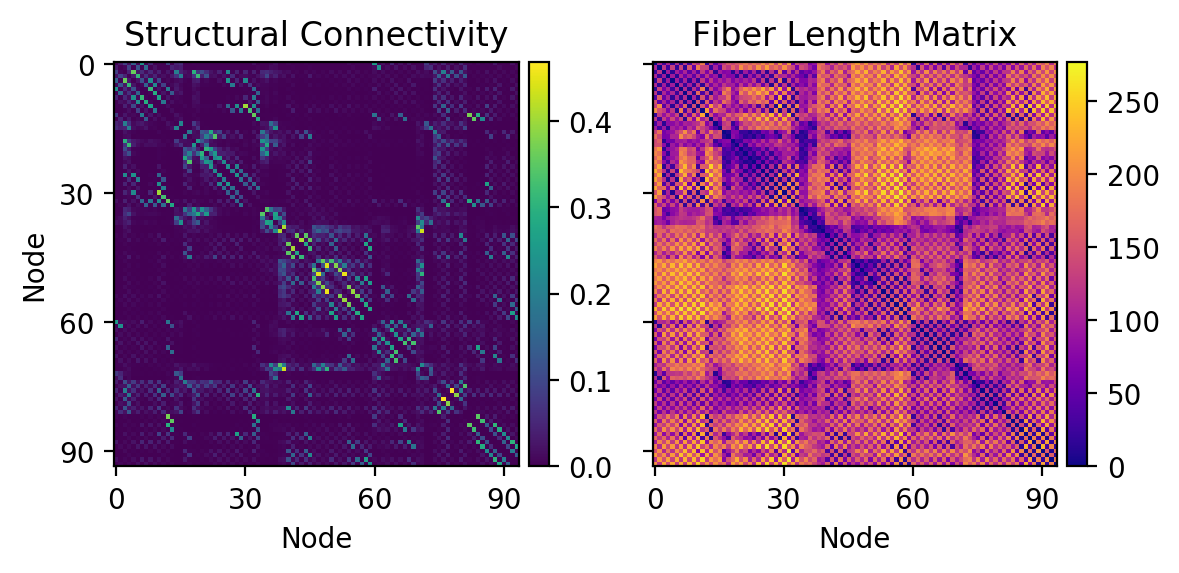

In [6]:
fig, ax = plt.subplots(1,2, dpi=200, sharey=True)
im=ax[0].imshow(par['SC'])
ax[0].set(title='Structural Connectivity', xlabel='Node', ylabel='Node', yticks=[0,30,60,90], xticks=[0,30,60,90])
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax = cax)

im=ax[1].imshow(par['DM'], cmap='plasma')
ax[1].set(title='Fiber Length Matrix', xlabel='Node', xticks=[0,30,60,90])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax = cax)
plt.tight_layout()


Weakest to strongest:  [72 25 31 73 83  1 68 57 82 79 29  7  9 65 24 27 66 90 91 67 93 69 87  0
 78 30 14 61  6 89 56 64 63 13 28 62 15  8 85 11 55 60 42  5 23 26 86 44
 36 20 58 43 92 22 84 12 50 16 59 33 48  4 88 51 52 10 19 74 17 53 81 34
 18 21 80 46 54 40 75 37 49 32 38 45 35 47  3 41 76  2 39 70 77 71]


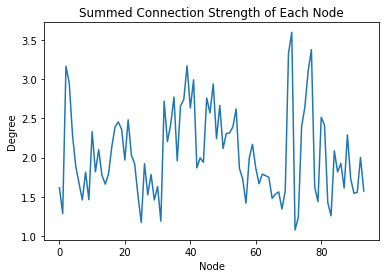

In [7]:
plt.plot(np.sum(par['SC'],axis=0))
plt.xlabel('Node'); plt.ylabel('Degree')
plt.title('Summed Connection Strength of Each Node')
print('Weakest to strongest: ', np.argsort(np.sum(par['SC'],axis=0)))

## Baseline correlation without stimulation

In [8]:
tstart=20000 # in unit of timesteps dt

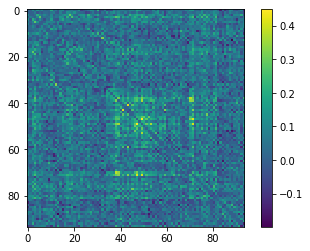

In [9]:
par = load_parameters()
par['K'] = 0.1
par['I'] = 0.52
par['sigma'] = 0.001
_, xs_base, _,_,_,_ = timeIntegrationRK4(par,randomseed=42)
PC_base = np.corrcoef(xs_base[:,tstart:])
np.fill_diagonal(PC_base,0)
plt.imshow(PC_base)
plt.colorbar()

## Stimulate Individual Nodes

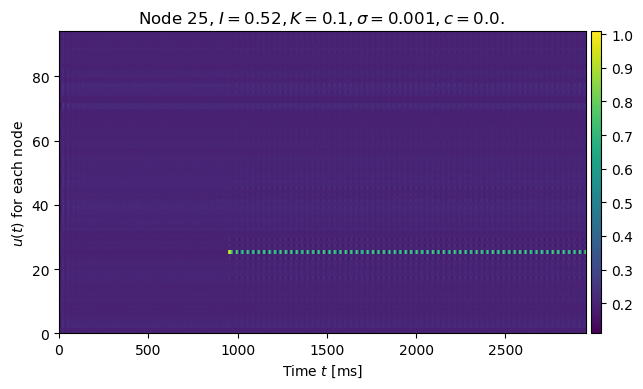

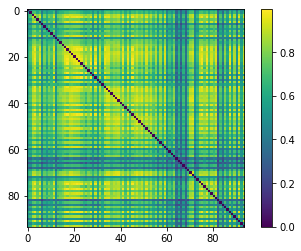

In [10]:
par = load_parameters()
par['K'] = 0.1
par['I'] = 0.52
par['sigma'] = 0.001
_,xs25,_,_,_,_ = timeIntegrationRK4(par, randomseed=42, stimNode=25)
plotSpikeTrain_ini(xs25[:,500:], par, 'Node 25, ')

PC25 = np.corrcoef(xs25[:,tstart:])
np.fill_diagonal(PC25,0)
plt.imshow(PC25); plt.colorbar()

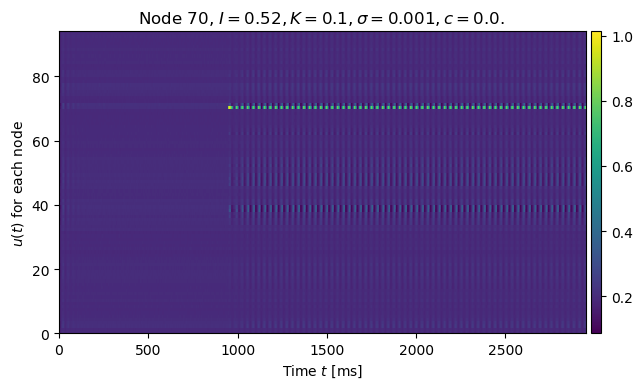

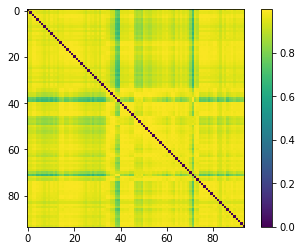

In [11]:
par = load_parameters()
par['K'] = 0.1
par['I'] = 0.52
par['sigma'] = 0.001
_,xs70,_,_,_,_ = timeIntegrationRK4(par, randomseed=42, stimNode=70)
plotSpikeTrain_ini(xs70[:,500:], par, 'Node 70, ')

PC70 = np.corrcoef(xs70[:,tstart:])
np.fill_diagonal(PC70,0)
plt.imshow(PC70); plt.colorbar()

0.884223099017001

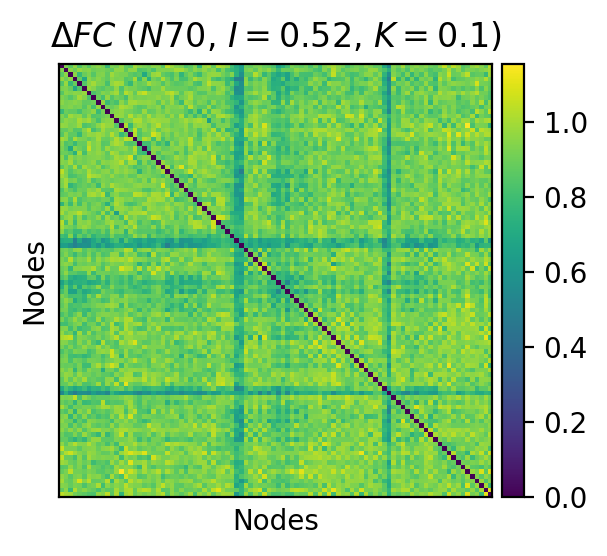

In [12]:
functional_effect(xs_base,xs70,70,tstart)

0.619804379535847

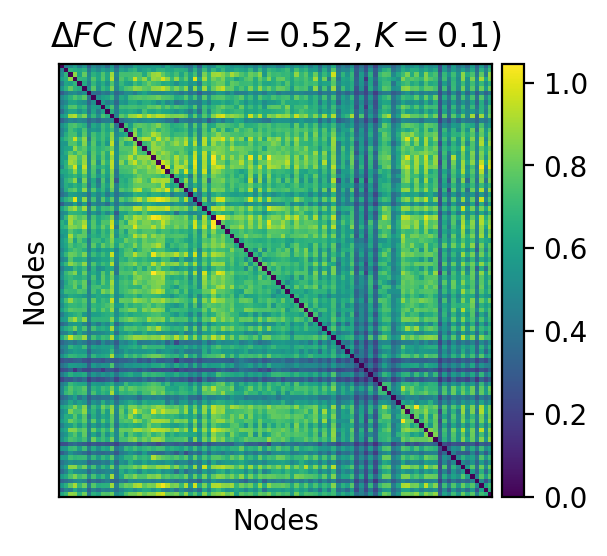

In [13]:
functional_effect(xs_base,xs25,25,tstart)

In [14]:
fes = []
for n in range(par['SC'].shape[0]):
    _,xs,_,_,_,_ = timeIntegrationRK4(par, randomseed=42, stimNode=n)
    fes.append(functional_effect(xs_base,xs,n,tstart,plot=False))


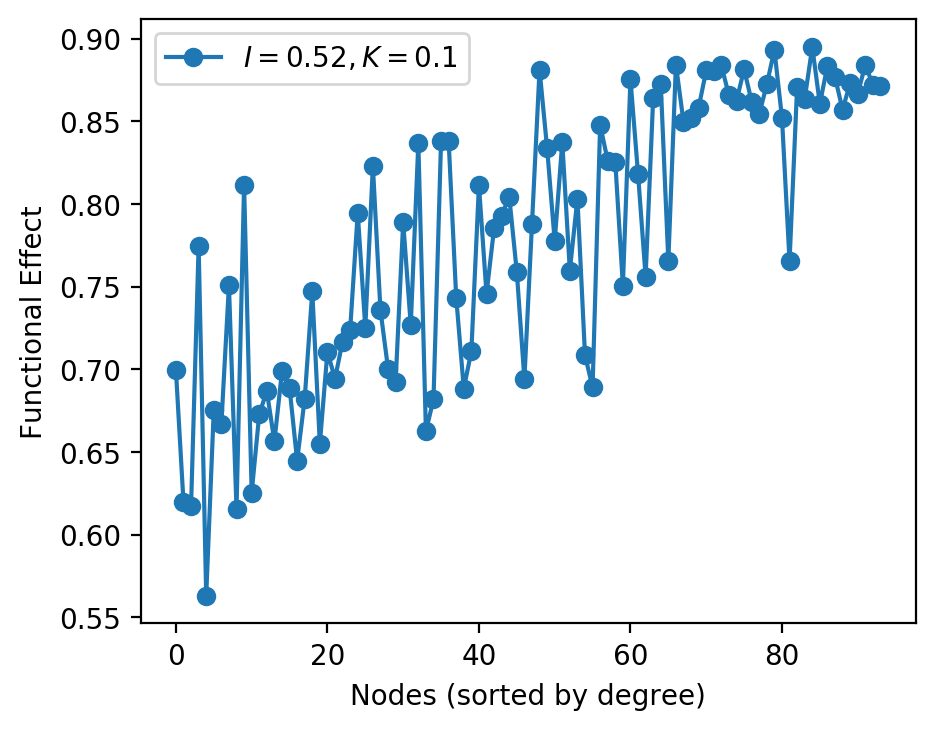

In [15]:
plt.figure(figsize=(5,4), dpi=200)
plt.plot(np.asarray(fes)[np.argsort(np.sum(par['SC'],axis=1))], 'o-',label=r'$I={}, K={}$'.format(par['I'],par['K']))
plt.xlabel('Nodes (sorted by degree)')
plt.ylabel('Functional Effect')
plt.legend();plt.show()

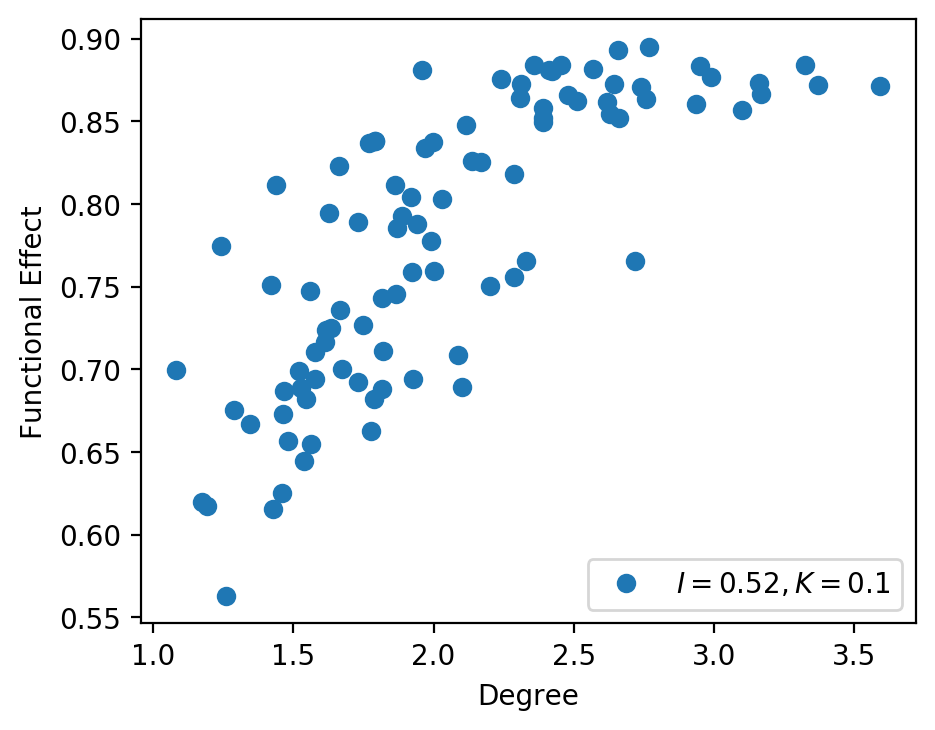

In [16]:
plt.figure(figsize=(5,4), dpi=200)
plt.plot(np.sum(par['SC'],axis=0),np.asarray(fes), 'o',label=r'$I={}, K={}$'.format(par['I'],par['K']))
plt.xlabel('Degree')
plt.ylabel('Functional Effect')
plt.legend();plt.show()

## Modal Controllability

Text(0.5, 0, 'Node')

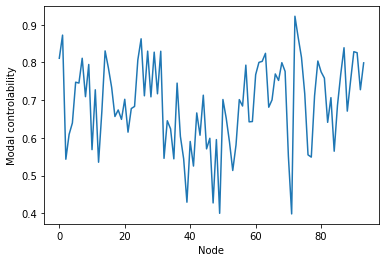

In [17]:
modal = calc_mod_control(par['SC'])        
plt.plot(modal)
plt.ylabel('Modal controlability')
plt.xlabel('Node')

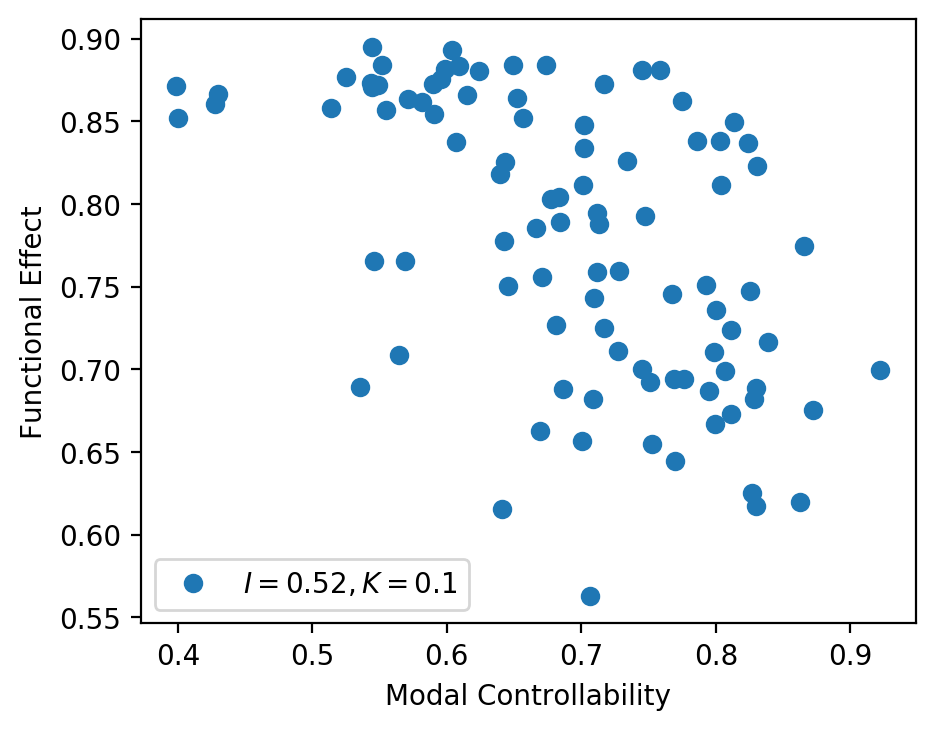

In [18]:
plt.figure(figsize=(5,4), dpi=200)
plt.plot(modal,np.asarray(fes), 'o',label=r'$I={}, K={}$'.format(par['I'],par['K']))
plt.xlabel('Modal Controllability')
plt.ylabel('Functional Effect')
plt.legend();plt.show()

## Average Controllability

## Different Bifurcation points
Fundamental difference is that their model only has one input parameter. Figure 2c) checks when different matrices transition (8 subjects, 3 scans per subject).

Here (for now) we just check for different parameter configuratios in that one network.

In [19]:
Ks = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

In [ ]:
std = 0
iterI = 0.35
while std < 0.1 :
    

# Individual subjects

In [20]:
SCs = np.load('SCs_m12_94_voxNorm.npy')

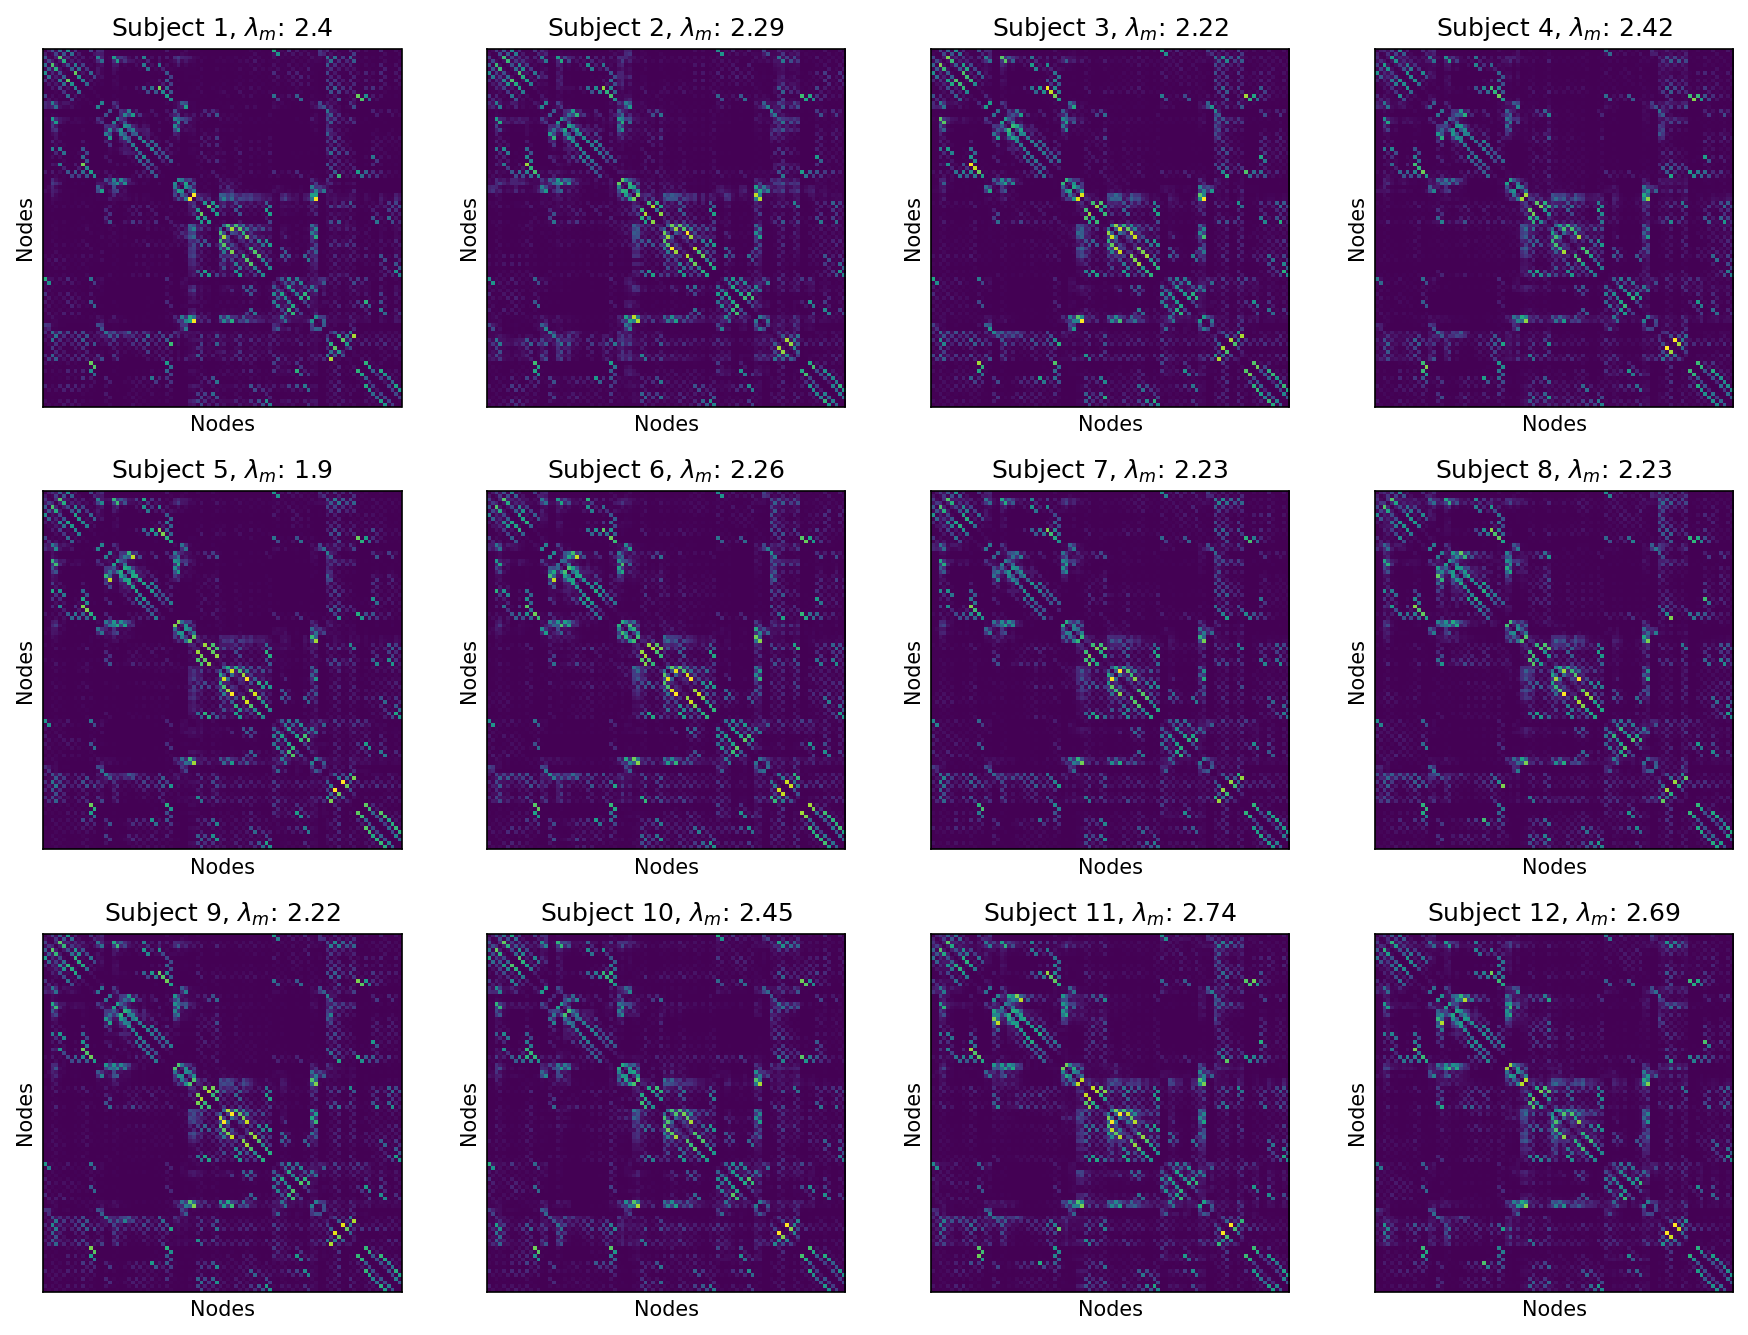

In [37]:
evs = []
fig, axs = plt.subplots(3,4,sharex=True, sharey=True, dpi=150,figsize=(12,9))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(SCs[i])
    ev = np.max(np.linalg.eig(SCs[i])[0])
    evs.append(ev)
    ax.set(title=r'Subject {}, $\lambda_m$: {}'.format(i+1, np.round(ev,2)), xlabel='Nodes', ylabel='Nodes', xticks=[], yticks=[])
plt.tight_layout()

Following the normalization procedure dscribed in the supplementary: https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1005076.s007&type=supplementary

In [40]:
evmax = max(evs)
SCs = SCs/(2*evmax)

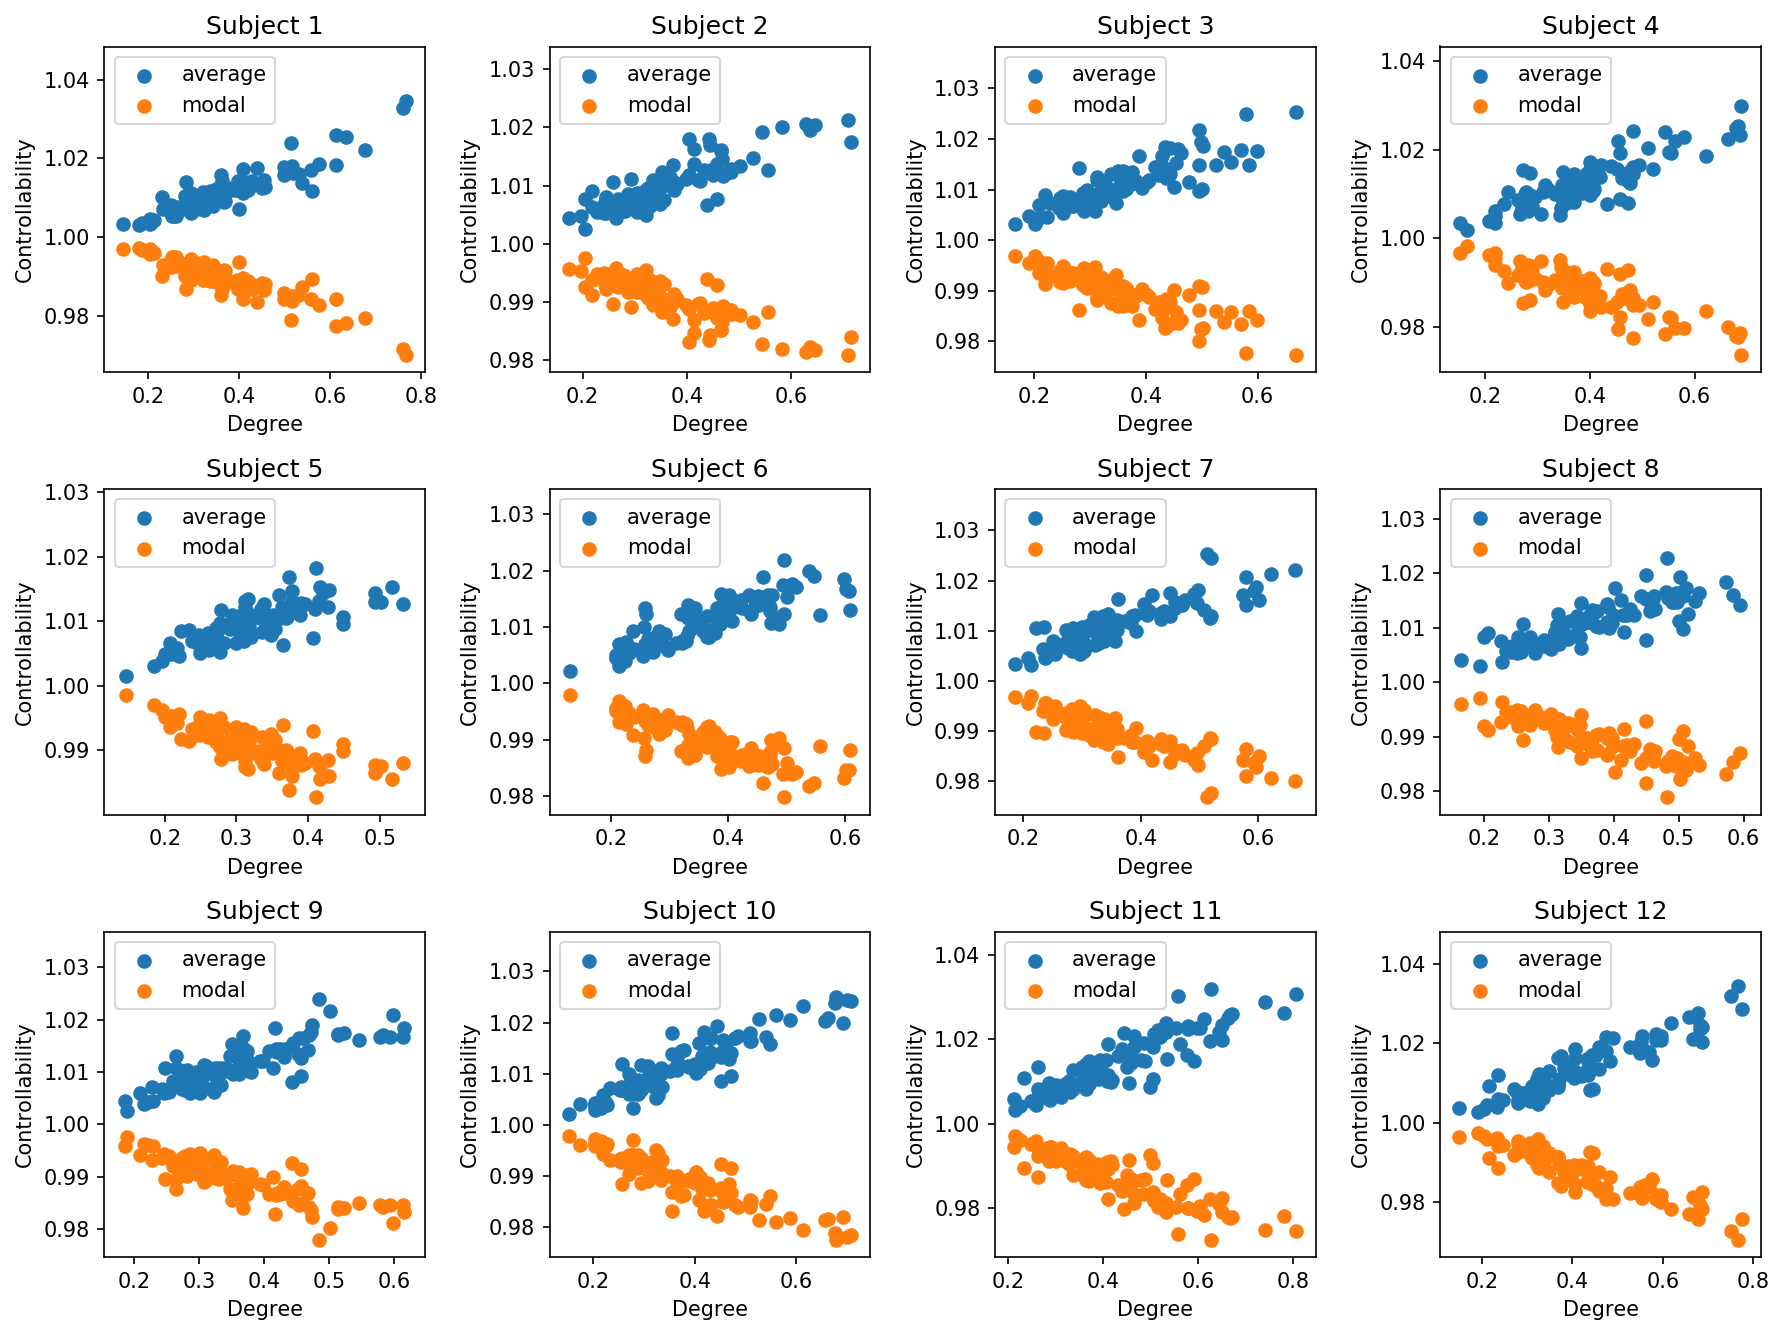

In [59]:
aves = []
mods = []
degs = []
fig, axs = plt.subplots(3,4, dpi=150,figsize=(12,9))
for i, ax in enumerate(axs.ravel()):
    ave_control = calc_ave_control(SCs[i])
    aves.append(ave_control)
    mod_control = calc_mod_control(SCs[i])
    mods.append(mod_control)
    degree = np.sum(SCs[i],axis=0)
    degs.append(degree)
    ax.scatter(degree, ave_control,label='average')
    ax.scatter(degree, mod_control,label='modal')
    ax.set(title=r'Subject {}'.format(i+1), xlabel='Degree', ylabel='Controllability')
    ax.legend(loc=2)
plt.tight_layout()

## Figure 3. Linear regional controllability.

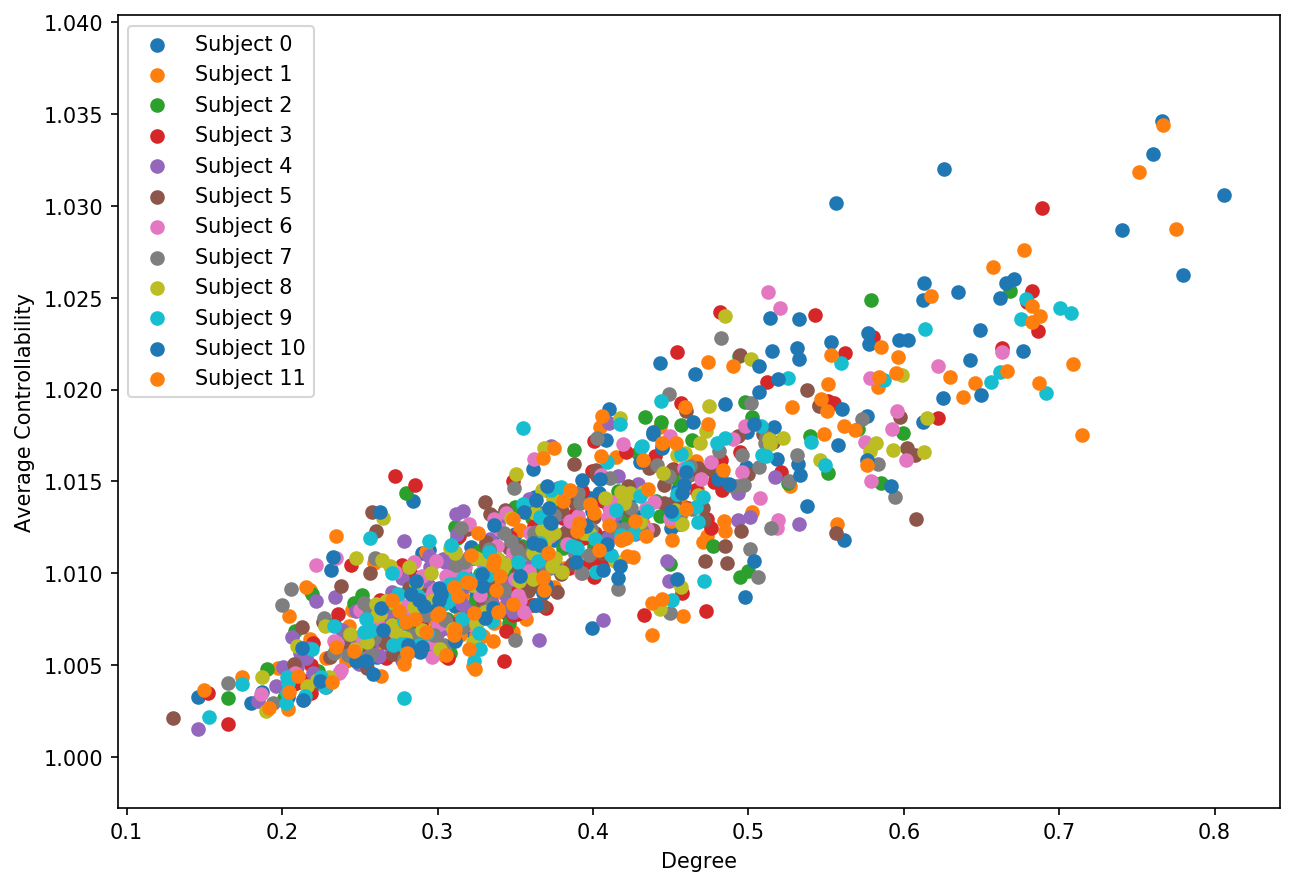

In [70]:
fig, ax = plt.subplots(figsize=(10,7),dpi=150)
for i in range(len(degs)):
    ax.scatter(degs[i],aves[i],  label='Subject {}'.format(i))
    ax.legend()
ax.set(ylabel='Average Controllability', xlabel='Degree')
plt.show()

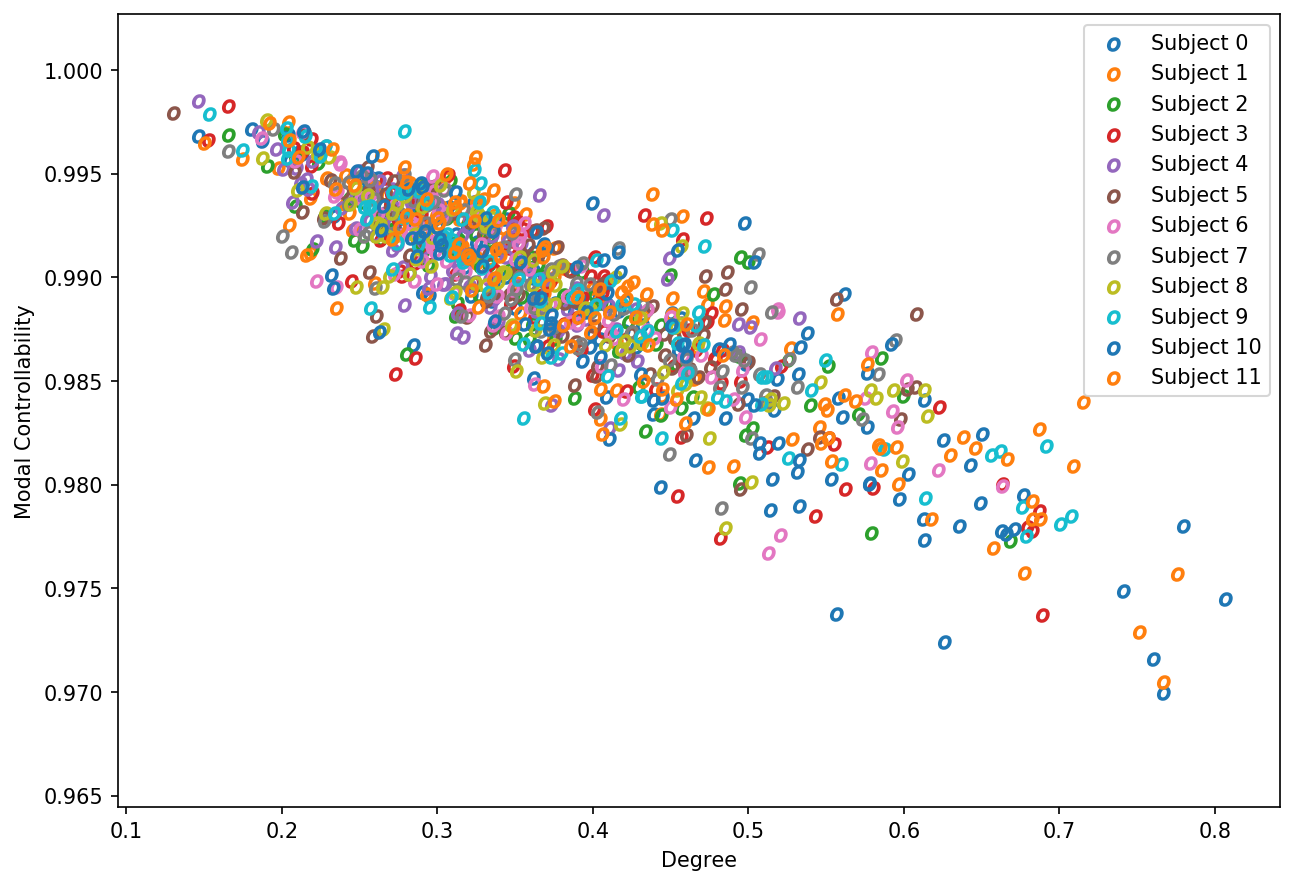

In [81]:
fig, ax = plt.subplots(figsize=(10,7),dpi=150)
for i in range(len(degs)):
    ax.scatter(degs[i],mods[i], marker='$O$', label='Subject {}'.format(i))
    ax.legend()
ax.set(ylabel='Modal Controllability', xlabel='Degree')
plt.show()

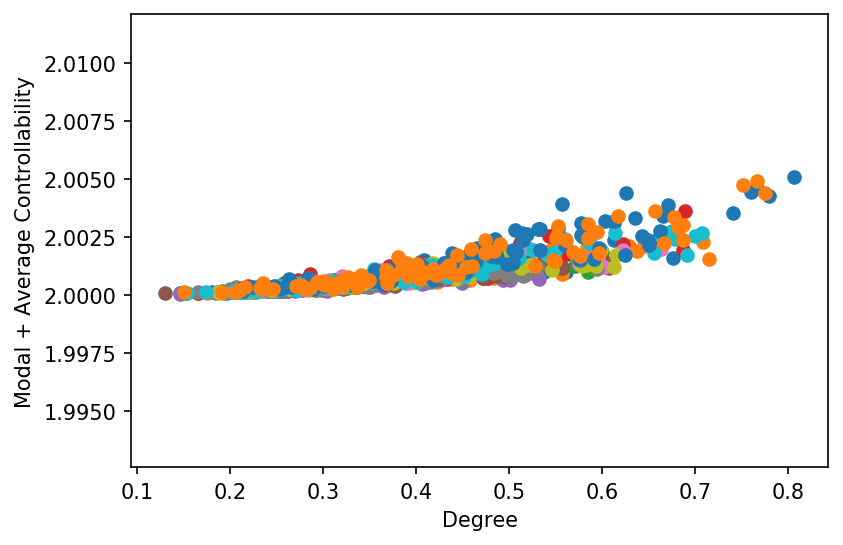

In [74]:
# Sanity check:
fig, ax = plt.subplots(dpi=150)
for i in range(len(degs)):
    ax.scatter(degs[i],mods[i]+aves[i],  label='Subject {}'.format(i))
    #ax.legend()
ax.set(ylabel='Modal + Average Controllability', xlabel='Degree')
plt.show()

## Find transition points for each subject
Use 3 different background inputs, $I_{ext} \in [0.5,0.6,0.7]$

In [82]:
evmax

2.735885333544352

1.0659541038894953

In [139]:
def find_k_transition(par,sub,thres,rs=42):
    kiter = 0.
    #_,xs,_,_,_,_ = timeIntegrationRK4(par, randomseed=rs)
    while True:
        kiter+=0.1
        par['K'] = kiter
        _,xs,_,_,_,_ = timeIntegrationRK4(par, randomseed=rs)
        if transition(xs,thres):
            print('Subject {}: 1e-1 Accuracy found!'.format(sub), kiter)
            break
    kiter-=0.1
    while True:
        kiter+=0.01
        par['K'] = kiter
        _,xs,_,_,_,_ = timeIntegrationRK4(par, randomseed=rs)
        if transition(xs,thres):
            print('Subject {}: 1e-2 Accuracy found!'.format(sub), kiter)
            break
    kiter-=0.01
    while True:
        kiter+=0.001
        par['K'] = kiter
        _,xs,_,_,_,_ = timeIntegrationRK4(par, randomseed=rs)
        if transition(xs,thres):
            print('Subject {}: 1e-3 Accuracy found!'.format(sub), kiter)
            break
    kiter=np.round(kiter-0.001, 6)
    return kiter

Subject 1: 1e-1 Accuracy found! 0.7
Subject 1: 1e-2 Accuracy found! 0.63
Subject 1: 1e-3 Accuracy found! 0.629
Subject 1: 1e-1 Accuracy found! 0.7
Subject 1: 1e-2 Accuracy found! 0.63
Subject 1: 1e-3 Accuracy found! 0.625


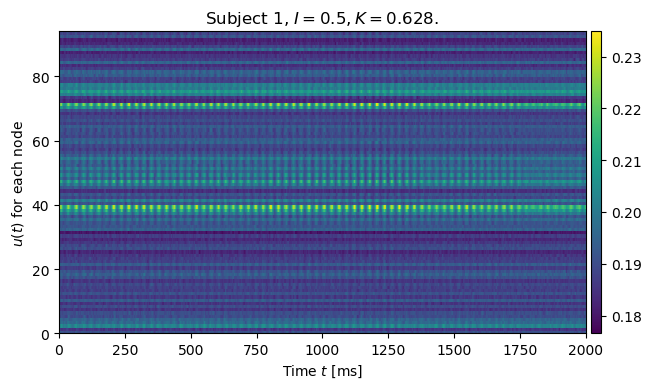

Subject 2: 1e-1 Accuracy found! 0.7
Subject 2: 1e-2 Accuracy found! 0.68
Subject 2: 1e-3 Accuracy found! 0.671
Subject 2: 1e-1 Accuracy found! 0.7
Subject 2: 1e-2 Accuracy found! 0.67
Subject 2: 1e-3 Accuracy found! 0.669


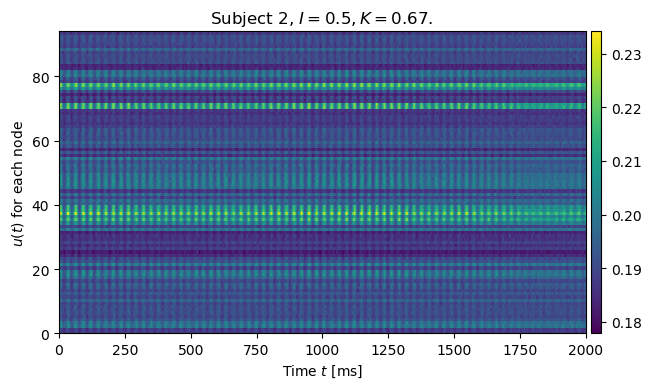

Subject 3: 1e-1 Accuracy found! 0.7
Subject 3: 1e-2 Accuracy found! 0.7000000000000001
Subject 3: 1e-3 Accuracy found! 0.6990000000000001
Subject 3: 1e-1 Accuracy found! 0.7
Subject 3: 1e-2 Accuracy found! 0.7000000000000001
Subject 3: 1e-3 Accuracy found! 0.6950000000000001


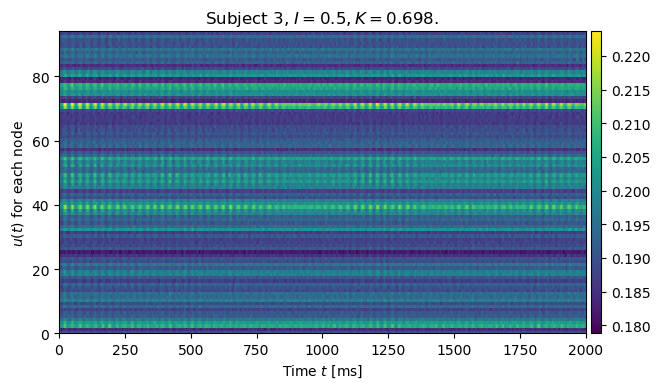

Subject 4: 1e-1 Accuracy found! 0.7
Subject 4: 1e-2 Accuracy found! 0.64
Subject 4: 1e-3 Accuracy found! 0.637
Subject 4: 1e-1 Accuracy found! 0.7
Subject 4: 1e-2 Accuracy found! 0.64
Subject 4: 1e-3 Accuracy found! 0.636


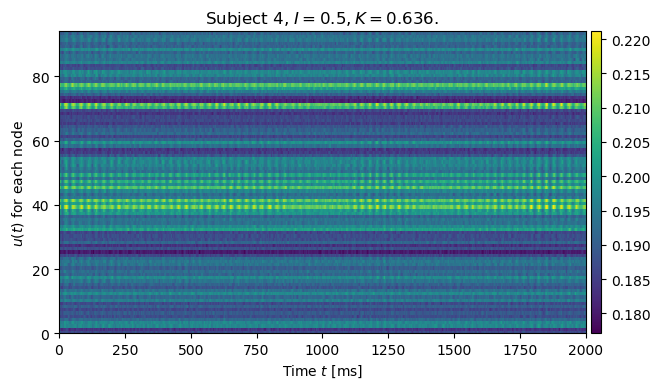

Subject 5: 1e-1 Accuracy found! 0.8999999999999999
Subject 5: 1e-2 Accuracy found! 0.84
Subject 5: 1e-3 Accuracy found! 0.831
Subject 5: 1e-1 Accuracy found! 0.8999999999999999
Subject 5: 1e-2 Accuracy found! 0.83
Subject 5: 1e-3 Accuracy found! 0.829


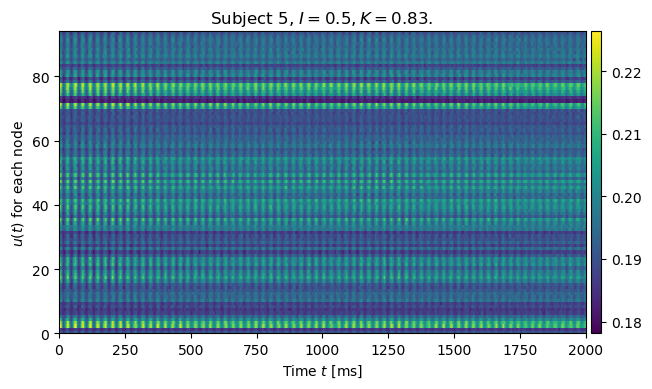

Subject 6: 1e-1 Accuracy found! 0.7
Subject 6: 1e-2 Accuracy found! 0.7000000000000001
Subject 6: 1e-3 Accuracy found! 0.6960000000000001
Subject 6: 1e-1 Accuracy found! 0.7
Subject 6: 1e-2 Accuracy found! 0.7000000000000001
Subject 6: 1e-3 Accuracy found! 0.6950000000000001


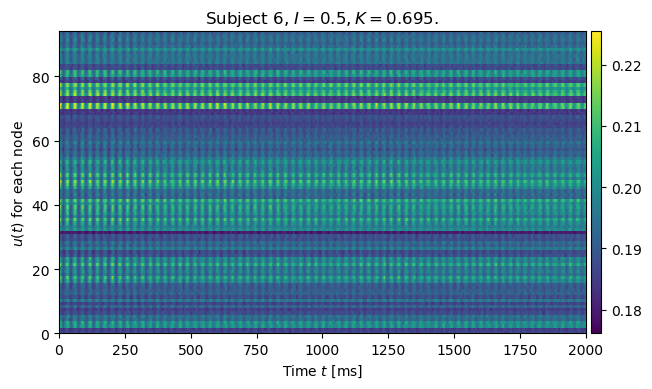

Subject 7: 1e-1 Accuracy found! 0.7
Subject 7: 1e-2 Accuracy found! 0.7000000000000001
Subject 7: 1e-3 Accuracy found! 0.6990000000000001
Subject 7: 1e-1 Accuracy found! 0.7
Subject 7: 1e-2 Accuracy found! 0.7000000000000001
Subject 7: 1e-3 Accuracy found! 0.6960000000000001


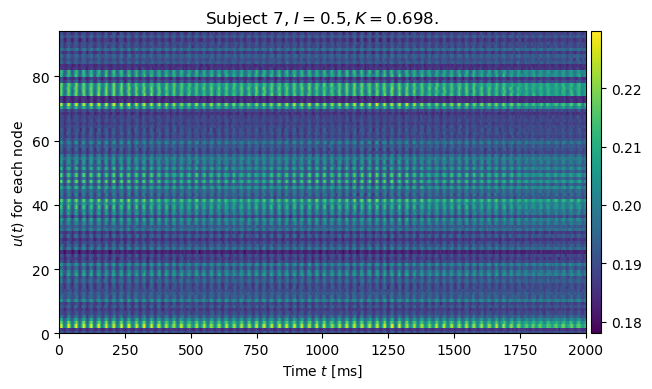

Subject 8: 1e-1 Accuracy found! 0.7999999999999999
Subject 8: 1e-2 Accuracy found! 0.71
Subject 8: 1e-3 Accuracy found! 0.708
Subject 8: 1e-1 Accuracy found! 0.7999999999999999
Subject 8: 1e-2 Accuracy found! 0.71
Subject 8: 1e-3 Accuracy found! 0.707


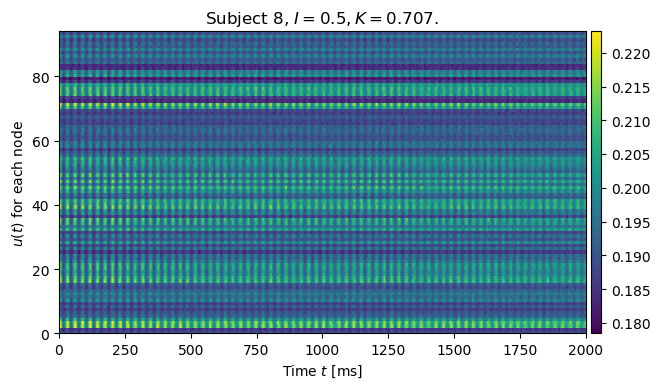

Subject 9: 1e-1 Accuracy found! 0.7999999999999999
Subject 9: 1e-2 Accuracy found! 0.71
Subject 9: 1e-3 Accuracy found! 0.705
Subject 9: 1e-1 Accuracy found! 0.7999999999999999
Subject 9: 1e-2 Accuracy found! 0.71
Subject 9: 1e-3 Accuracy found! 0.704


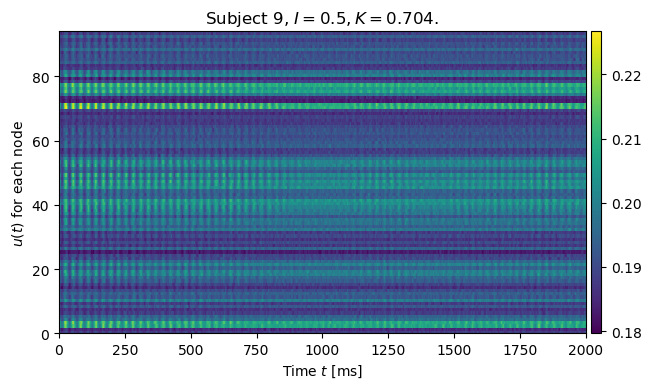

Subject 10: 1e-1 Accuracy found! 0.7
Subject 10: 1e-2 Accuracy found! 0.64
Subject 10: 1e-3 Accuracy found! 0.631
Subject 10: 1e-1 Accuracy found! 0.7
Subject 10: 1e-2 Accuracy found! 0.63
Subject 10: 1e-3 Accuracy found! 0.629


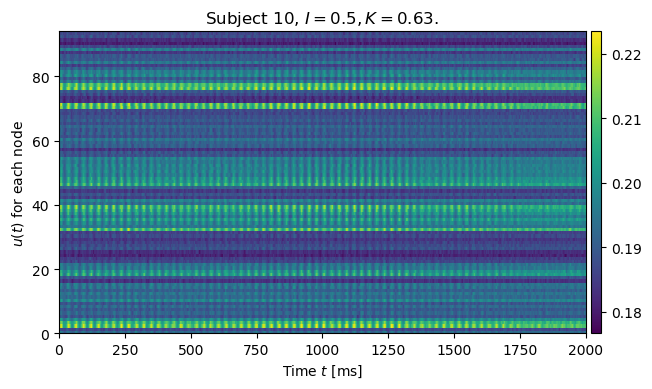

Subject 11: 1e-1 Accuracy found! 0.6
Subject 11: 1e-2 Accuracy found! 0.5700000000000001
Subject 11: 1e-3 Accuracy found! 0.5680000000000001
Subject 11: 1e-1 Accuracy found! 0.6
Subject 11: 1e-2 Accuracy found! 0.5700000000000001
Subject 11: 1e-3 Accuracy found! 0.5670000000000001


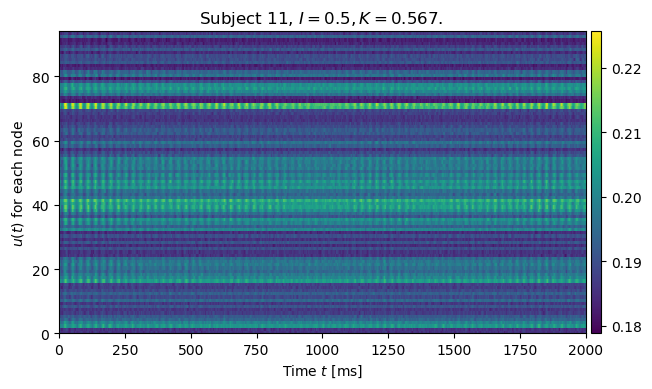

Subject 12: 1e-1 Accuracy found! 0.6
Subject 12: 1e-2 Accuracy found! 0.5800000000000001
Subject 12: 1e-3 Accuracy found! 0.5750000000000001
Subject 12: 1e-1 Accuracy found! 0.6
Subject 12: 1e-2 Accuracy found! 0.5800000000000001
Subject 12: 1e-3 Accuracy found! 0.5730000000000001


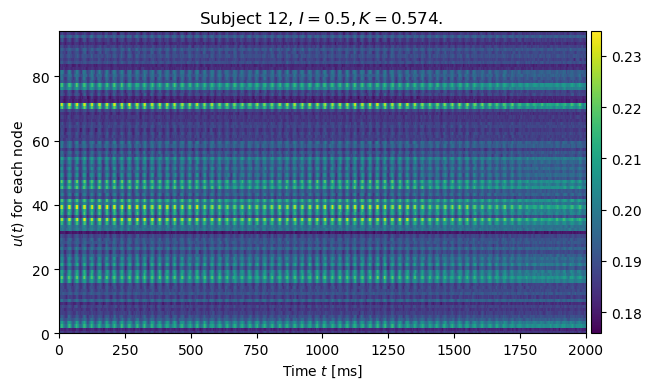

In [117]:
par = load_parameters()
par['sigma'] = 0.001
#for i in Is:
par['I'] = 0.5
KsI05 = []
KsI05_seed1 = []
for i, SC in enumerate(SCs):
    par['SC'] = SC
    par['K'] = 0.
    K_I05 = find_k_transition(par,i+1,0.02)
    K_I05_seed1 = find_k_transition(par,i+1,0.02,rs=1)
    par['K'] = K_I05
    _,xs,_,_,_,_ = timeIntegrationRK4(par, randomseed=42)
    plotSpikeTrain_ini(xs[:,10000:], par, 'Subject {}, '.format(i+1))
    KsI05.append(K_I05)
    KsI05_seed1.append(K_I05_seed1)


Text(0.5, 1.0, 'Transistions for $I_{ext}=0.5$')

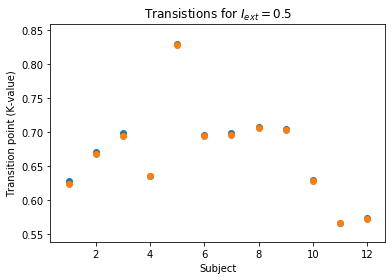

In [133]:
plt.scatter([x+1 for x in range(12)], KsI05)
plt.scatter([x+1 for x in range(12)], KsI05_seed1)
plt.xlabel('Subject')
plt.ylabel('Transition point (K-value)')
plt.title(r'Transistions for $I_{ext}=0.5$')

Subject 1: 1e-1 Accuracy found! 0.4
Subject 1: 1e-2 Accuracy found! 0.33000000000000007
Subject 1: 1e-3 Accuracy found! 0.32100000000000006
Subject 1: 1e-1 Accuracy found! 0.4
Subject 1: 1e-2 Accuracy found! 0.33000000000000007
Subject 1: 1e-3 Accuracy found! 0.32100000000000006
Subject 1: 1e-1 Accuracy found! 0.4
Subject 1: 1e-2 Accuracy found! 0.33000000000000007
Subject 1: 1e-3 Accuracy found! 0.32100000000000006


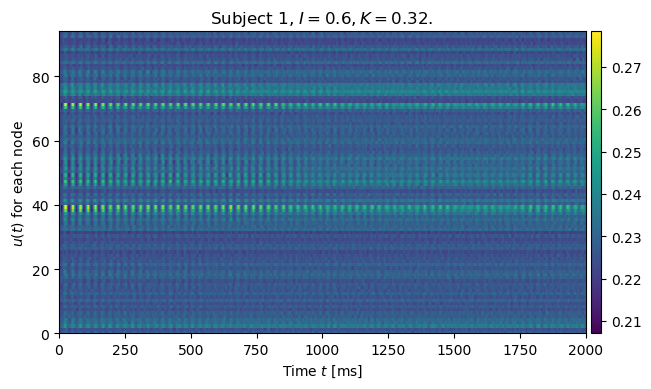

Subject 2: 1e-1 Accuracy found! 0.4
Subject 2: 1e-2 Accuracy found! 0.3500000000000001
Subject 2: 1e-3 Accuracy found! 0.3430000000000001
Subject 2: 1e-1 Accuracy found! 0.4
Subject 2: 1e-2 Accuracy found! 0.3500000000000001
Subject 2: 1e-3 Accuracy found! 0.3420000000000001
Subject 2: 1e-1 Accuracy found! 0.4
Subject 2: 1e-2 Accuracy found! 0.3500000000000001
Subject 2: 1e-3 Accuracy found! 0.3420000000000001


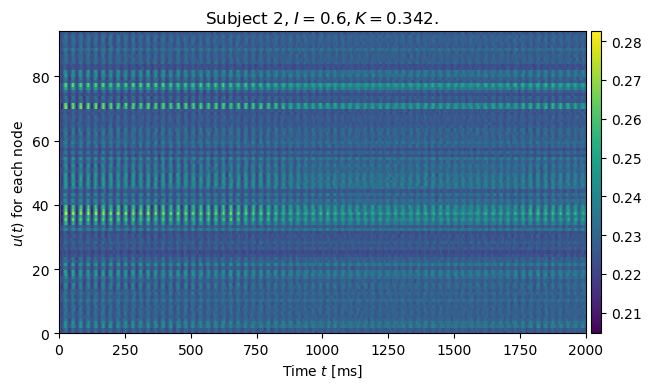

Subject 3: 1e-1 Accuracy found! 0.4
Subject 3: 1e-2 Accuracy found! 0.3600000000000001
Subject 3: 1e-3 Accuracy found! 0.3570000000000001
Subject 3: 1e-1 Accuracy found! 0.4
Subject 3: 1e-2 Accuracy found! 0.3600000000000001
Subject 3: 1e-3 Accuracy found! 0.3570000000000001
Subject 3: 1e-1 Accuracy found! 0.4
Subject 3: 1e-2 Accuracy found! 0.3600000000000001
Subject 3: 1e-3 Accuracy found! 0.3560000000000001


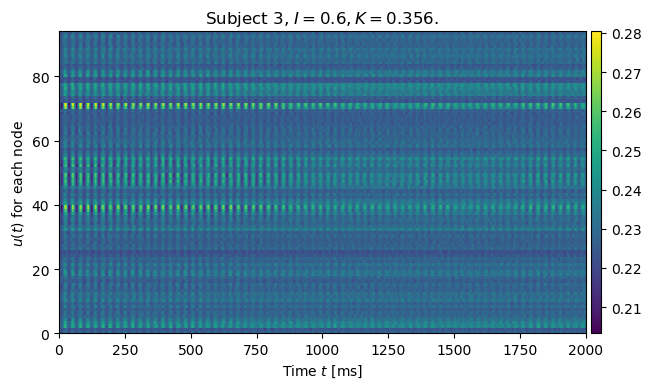

Subject 4: 1e-1 Accuracy found! 0.4
Subject 4: 1e-2 Accuracy found! 0.33000000000000007
Subject 4: 1e-3 Accuracy found! 0.32600000000000007
Subject 4: 1e-1 Accuracy found! 0.4
Subject 4: 1e-2 Accuracy found! 0.33000000000000007
Subject 4: 1e-3 Accuracy found! 0.32600000000000007
Subject 4: 1e-1 Accuracy found! 0.4
Subject 4: 1e-2 Accuracy found! 0.33000000000000007
Subject 4: 1e-3 Accuracy found! 0.32600000000000007


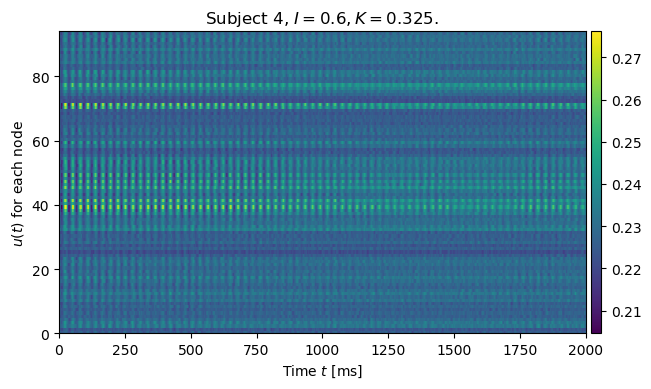

Subject 5: 1e-1 Accuracy found! 0.5
Subject 5: 1e-2 Accuracy found! 0.43000000000000005
Subject 5: 1e-3 Accuracy found! 0.42600000000000005
Subject 5: 1e-1 Accuracy found! 0.5
Subject 5: 1e-2 Accuracy found! 0.43000000000000005
Subject 5: 1e-3 Accuracy found! 0.42600000000000005
Subject 5: 1e-1 Accuracy found! 0.5
Subject 5: 1e-2 Accuracy found! 0.43000000000000005
Subject 5: 1e-3 Accuracy found! 0.42500000000000004


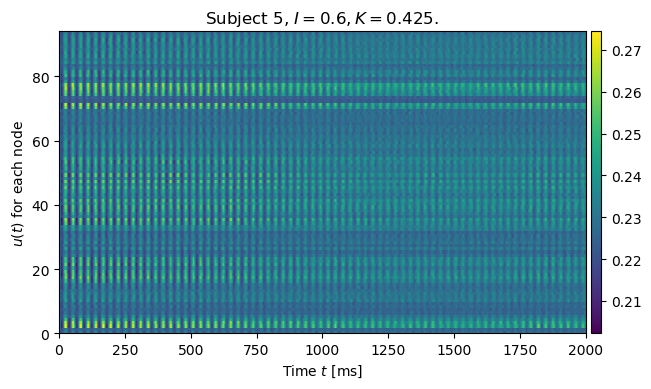

Subject 6: 1e-1 Accuracy found! 0.4
Subject 6: 1e-2 Accuracy found! 0.3600000000000001
Subject 6: 1e-3 Accuracy found! 0.3560000000000001
Subject 6: 1e-1 Accuracy found! 0.4
Subject 6: 1e-2 Accuracy found! 0.3600000000000001
Subject 6: 1e-3 Accuracy found! 0.3560000000000001
Subject 6: 1e-1 Accuracy found! 0.4
Subject 6: 1e-2 Accuracy found! 0.3600000000000001
Subject 6: 1e-3 Accuracy found! 0.3560000000000001


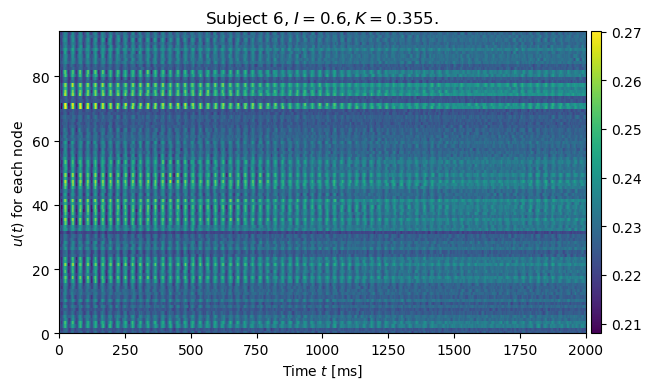

Subject 7: 1e-1 Accuracy found! 0.4
Subject 7: 1e-2 Accuracy found! 0.3600000000000001
Subject 7: 1e-3 Accuracy found! 0.3580000000000001
Subject 7: 1e-1 Accuracy found! 0.4
Subject 7: 1e-2 Accuracy found! 0.3600000000000001
Subject 7: 1e-3 Accuracy found! 0.3570000000000001
Subject 7: 1e-1 Accuracy found! 0.4
Subject 7: 1e-2 Accuracy found! 0.3600000000000001
Subject 7: 1e-3 Accuracy found! 0.3570000000000001


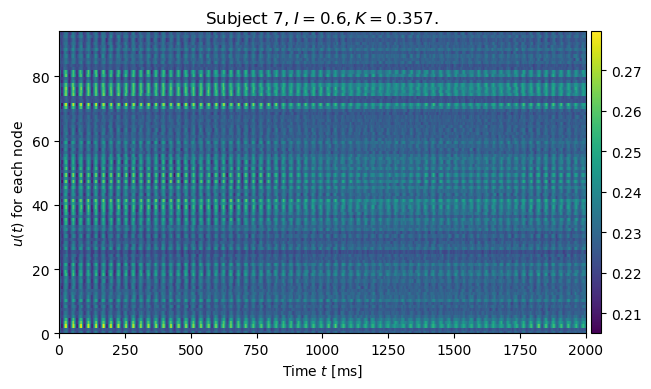

Subject 8: 1e-1 Accuracy found! 0.4
Subject 8: 1e-2 Accuracy found! 0.3700000000000001
Subject 8: 1e-3 Accuracy found! 0.3630000000000001
Subject 8: 1e-1 Accuracy found! 0.4
Subject 8: 1e-2 Accuracy found! 0.3700000000000001
Subject 8: 1e-3 Accuracy found! 0.3630000000000001
Subject 8: 1e-1 Accuracy found! 0.4
Subject 8: 1e-2 Accuracy found! 0.3700000000000001
Subject 8: 1e-3 Accuracy found! 0.3620000000000001


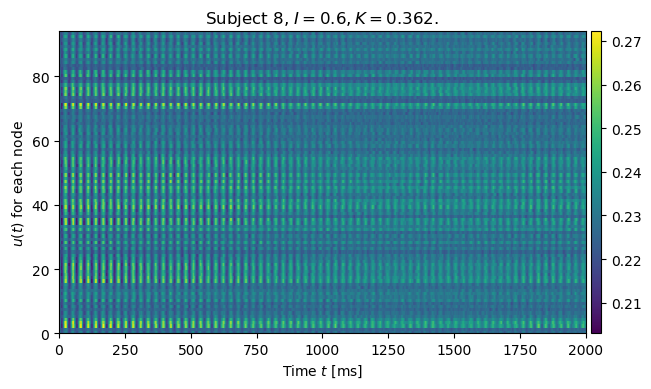

Subject 9: 1e-1 Accuracy found! 0.4
Subject 9: 1e-2 Accuracy found! 0.3700000000000001
Subject 9: 1e-3 Accuracy found! 0.3610000000000001
Subject 9: 1e-1 Accuracy found! 0.4
Subject 9: 1e-2 Accuracy found! 0.3700000000000001
Subject 9: 1e-3 Accuracy found! 0.3610000000000001
Subject 9: 1e-1 Accuracy found! 0.4
Subject 9: 1e-2 Accuracy found! 0.3700000000000001
Subject 9: 1e-3 Accuracy found! 0.3610000000000001


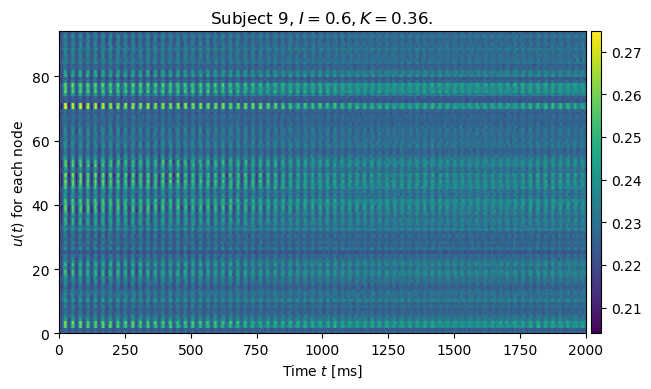

Subject 10: 1e-1 Accuracy found! 0.4
Subject 10: 1e-2 Accuracy found! 0.33000000000000007
Subject 10: 1e-3 Accuracy found! 0.32300000000000006
Subject 10: 1e-1 Accuracy found! 0.4
Subject 10: 1e-2 Accuracy found! 0.33000000000000007
Subject 10: 1e-3 Accuracy found! 0.32300000000000006
Subject 10: 1e-1 Accuracy found! 0.4
Subject 10: 1e-2 Accuracy found! 0.33000000000000007
Subject 10: 1e-3 Accuracy found! 0.32200000000000006


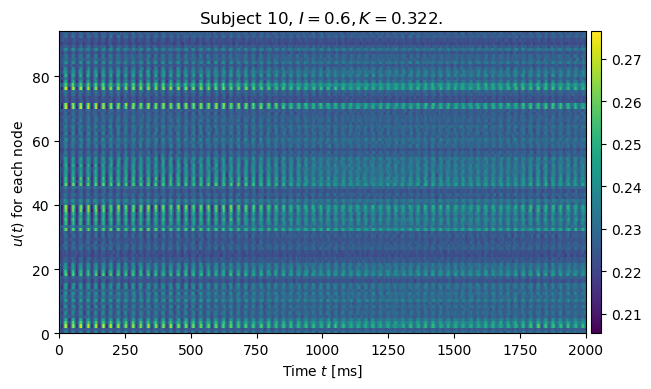

Subject 11: 1e-1 Accuracy found! 0.30000000000000004
Subject 11: 1e-2 Accuracy found! 0.3000000000000001
Subject 11: 1e-3 Accuracy found! 0.2910000000000001
Subject 11: 1e-1 Accuracy found! 0.30000000000000004
Subject 11: 1e-2 Accuracy found! 0.3000000000000001
Subject 11: 1e-3 Accuracy found! 0.2910000000000001
Subject 11: 1e-1 Accuracy found! 0.30000000000000004
Subject 11: 1e-2 Accuracy found! 0.3000000000000001
Subject 11: 1e-3 Accuracy found! 0.2910000000000001


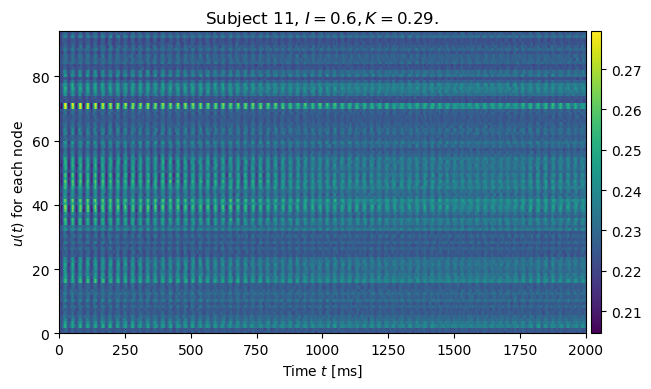

Subject 12: 1e-1 Accuracy found! 0.30000000000000004
Subject 12: 1e-2 Accuracy found! 0.3000000000000001
Subject 12: 1e-3 Accuracy found! 0.2940000000000001
Subject 12: 1e-1 Accuracy found! 0.30000000000000004
Subject 12: 1e-2 Accuracy found! 0.3000000000000001
Subject 12: 1e-3 Accuracy found! 0.2940000000000001
Subject 12: 1e-1 Accuracy found! 0.30000000000000004
Subject 12: 1e-2 Accuracy found! 0.3000000000000001
Subject 12: 1e-3 Accuracy found! 0.2930000000000001


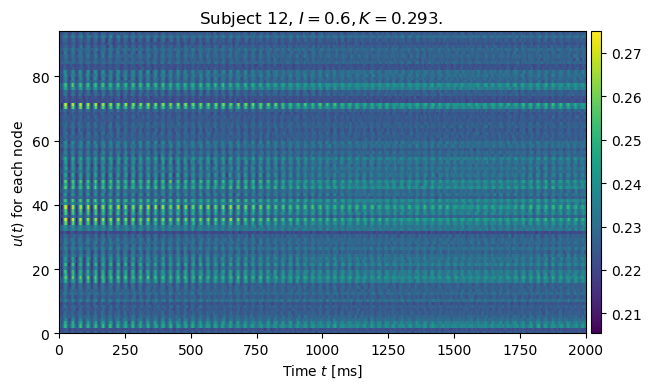

In [144]:
par = load_parameters()
par['sigma'] = 0.001
par['I'] = 0.6
KsI06 = []
KsI06_seed1 = []
KsI06_seed2 = []
for i, SC in enumerate(SCs):
    par['SC'] = SC
    par['K'] = 0.
    K_I06 = find_k_transition(par,i+1, thres=0.04)
    K_I06_seed1 = find_k_transition(par,i+1,rs=1, thres=0.04)
    K_I06_seed2 = find_k_transition(par,i+1,rs=2, thres=0.04)
    par['K'] = K_I06
    _,xs,_,_,_,_ = timeIntegrationRK4(par, randomseed=42)
    plotSpikeTrain_ini(xs[:,10000:], par, 'Subject {}, '.format(i+1))
    KsI06.append(K_I06)
    KsI06_seed1.append(K_I06_seed1)
    KsI06_seed2.append(K_I06_seed2)


Text(0.5, 1.0, 'Transistions for $I_{ext}=0.6$')

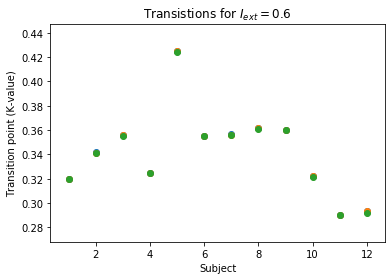

In [145]:
plt.scatter([x+1 for x in range(12)], KsI06)
plt.scatter([x+1 for x in range(12)], KsI06_seed1)
plt.scatter([x+1 for x in range(12)], KsI06_seed2)
plt.xlabel('Subject')
plt.ylabel('Transition point (K-value)')
plt.title(r'Transistions for $I_{ext}=0.6$')

Subject 1: 1e-1 Accuracy found! 0.1
Subject 1: 1e-2 Accuracy found! 0.07
Subject 1: 1e-3 Accuracy found! 0.063
Subject 1: 1e-1 Accuracy found! 0.1
Subject 1: 1e-2 Accuracy found! 0.07
Subject 1: 1e-3 Accuracy found! 0.062000000000000006
Subject 1: 1e-1 Accuracy found! 0.1
Subject 1: 1e-2 Accuracy found! 0.07
Subject 1: 1e-3 Accuracy found! 0.063


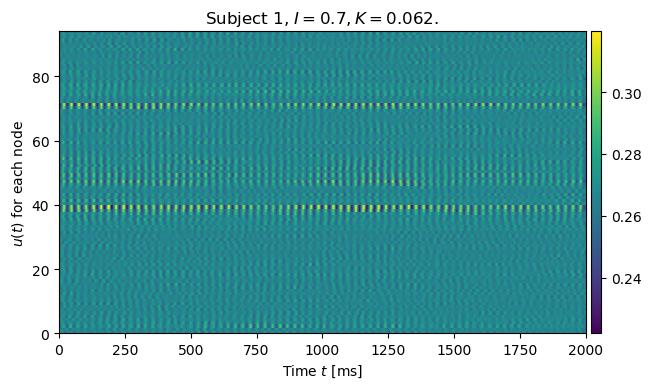

Subject 2: 1e-1 Accuracy found! 0.1
Subject 2: 1e-2 Accuracy found! 0.07
Subject 2: 1e-3 Accuracy found! 0.067
Subject 2: 1e-1 Accuracy found! 0.1
Subject 2: 1e-2 Accuracy found! 0.07
Subject 2: 1e-3 Accuracy found! 0.068
Subject 2: 1e-1 Accuracy found! 0.1
Subject 2: 1e-2 Accuracy found! 0.07
Subject 2: 1e-3 Accuracy found! 0.067


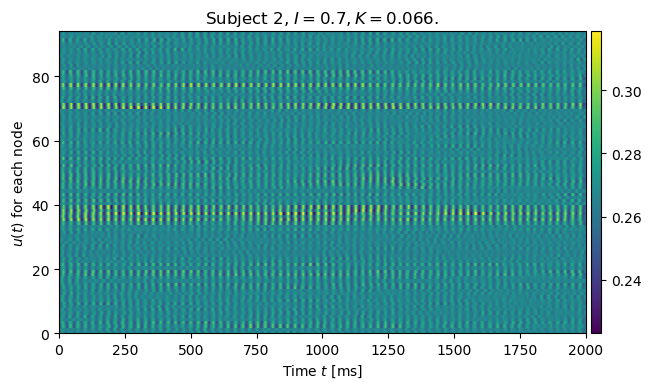

Subject 3: 1e-1 Accuracy found! 0.1
Subject 3: 1e-2 Accuracy found! 0.07
Subject 3: 1e-3 Accuracy found! 0.069
Subject 3: 1e-1 Accuracy found! 0.1
Subject 3: 1e-2 Accuracy found! 0.07
Subject 3: 1e-3 Accuracy found! 0.069
Subject 3: 1e-1 Accuracy found! 0.1
Subject 3: 1e-2 Accuracy found! 0.07
Subject 3: 1e-3 Accuracy found! 0.07


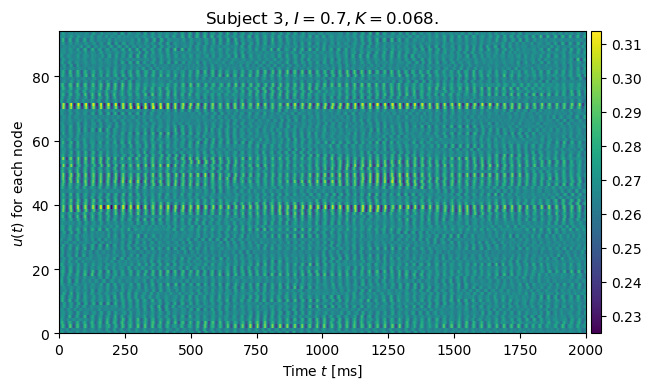

Subject 4: 1e-1 Accuracy found! 0.1
Subject 4: 1e-2 Accuracy found! 0.07
Subject 4: 1e-3 Accuracy found! 0.064
Subject 4: 1e-1 Accuracy found! 0.1
Subject 4: 1e-2 Accuracy found! 0.07
Subject 4: 1e-3 Accuracy found! 0.063
Subject 4: 1e-1 Accuracy found! 0.1
Subject 4: 1e-2 Accuracy found! 0.07
Subject 4: 1e-3 Accuracy found! 0.064


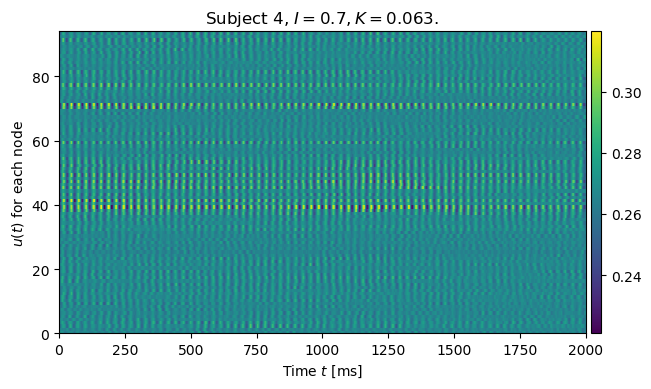

Subject 5: 1e-1 Accuracy found! 0.1
Subject 5: 1e-2 Accuracy found! 0.09
Subject 5: 1e-3 Accuracy found! 0.083
Subject 5: 1e-1 Accuracy found! 0.1
Subject 5: 1e-2 Accuracy found! 0.09
Subject 5: 1e-3 Accuracy found! 0.081
Subject 5: 1e-1 Accuracy found! 0.1
Subject 5: 1e-2 Accuracy found! 0.09
Subject 5: 1e-3 Accuracy found! 0.083


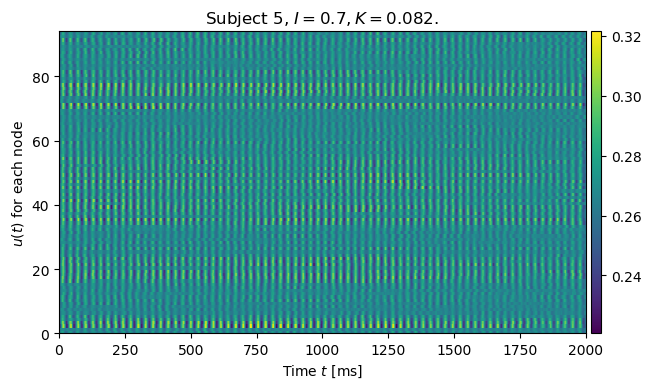

Subject 6: 1e-1 Accuracy found! 0.1
Subject 6: 1e-2 Accuracy found! 0.07
Subject 6: 1e-3 Accuracy found! 0.069
Subject 6: 1e-1 Accuracy found! 0.1
Subject 6: 1e-2 Accuracy found! 0.07
Subject 6: 1e-3 Accuracy found! 0.07
Subject 6: 1e-1 Accuracy found! 0.1
Subject 6: 1e-2 Accuracy found! 0.07
Subject 6: 1e-3 Accuracy found! 0.07


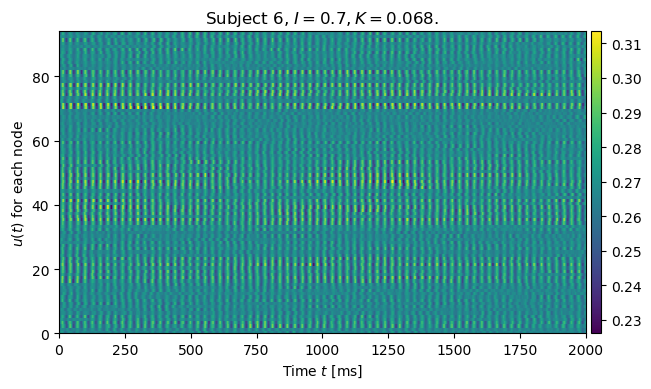

Subject 7: 1e-1 Accuracy found! 0.1
Subject 7: 1e-2 Accuracy found! 0.07
Subject 7: 1e-3 Accuracy found! 0.069
Subject 7: 1e-1 Accuracy found! 0.1
Subject 7: 1e-2 Accuracy found! 0.07
Subject 7: 1e-3 Accuracy found! 0.068
Subject 7: 1e-1 Accuracy found! 0.1
Subject 7: 1e-2 Accuracy found! 0.07
Subject 7: 1e-3 Accuracy found! 0.07


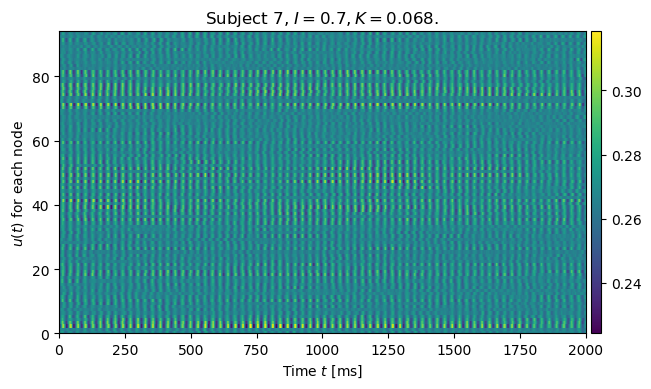

Subject 8: 1e-1 Accuracy found! 0.1
Subject 8: 1e-2 Accuracy found! 0.08
Subject 8: 1e-3 Accuracy found! 0.07100000000000001
Subject 8: 1e-1 Accuracy found! 0.1
Subject 8: 1e-2 Accuracy found! 0.07
Subject 8: 1e-3 Accuracy found! 0.07
Subject 8: 1e-1 Accuracy found! 0.1
Subject 8: 1e-2 Accuracy found! 0.08
Subject 8: 1e-3 Accuracy found! 0.07100000000000001


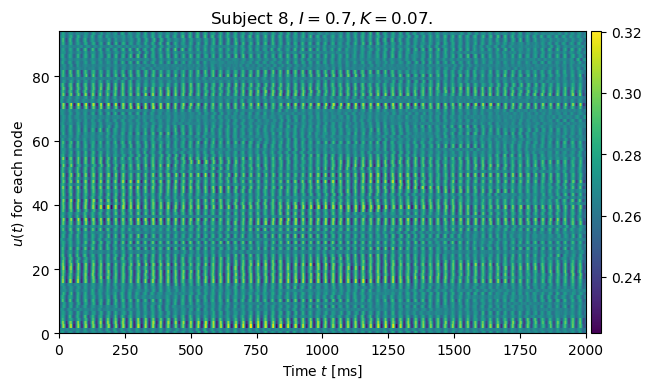

Subject 9: 1e-1 Accuracy found! 0.1
Subject 9: 1e-2 Accuracy found! 0.07
Subject 9: 1e-3 Accuracy found! 0.07
Subject 9: 1e-1 Accuracy found! 0.1
Subject 9: 1e-2 Accuracy found! 0.08
Subject 9: 1e-3 Accuracy found! 0.07100000000000001
Subject 9: 1e-1 Accuracy found! 0.1
Subject 9: 1e-2 Accuracy found! 0.08
Subject 9: 1e-3 Accuracy found! 0.07100000000000001


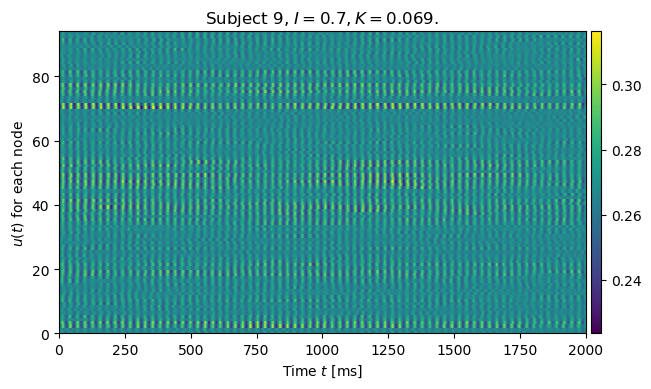

Subject 10: 1e-1 Accuracy found! 0.1
Subject 10: 1e-2 Accuracy found! 0.07
Subject 10: 1e-3 Accuracy found! 0.063
Subject 10: 1e-1 Accuracy found! 0.1
Subject 10: 1e-2 Accuracy found! 0.07
Subject 10: 1e-3 Accuracy found! 0.063
Subject 10: 1e-1 Accuracy found! 0.1
Subject 10: 1e-2 Accuracy found! 0.07
Subject 10: 1e-3 Accuracy found! 0.063


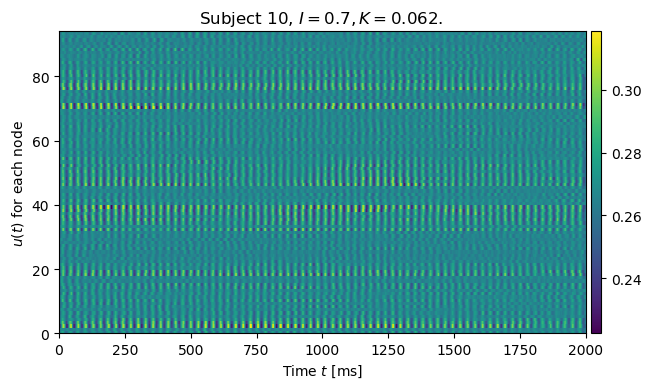

Subject 11: 1e-1 Accuracy found! 0.1
Subject 11: 1e-2 Accuracy found! 0.060000000000000005
Subject 11: 1e-3 Accuracy found! 0.05700000000000001
Subject 11: 1e-1 Accuracy found! 0.1
Subject 11: 1e-2 Accuracy found! 0.060000000000000005
Subject 11: 1e-3 Accuracy found! 0.05700000000000001
Subject 11: 1e-1 Accuracy found! 0.1
Subject 11: 1e-2 Accuracy found! 0.060000000000000005
Subject 11: 1e-3 Accuracy found! 0.05700000000000001


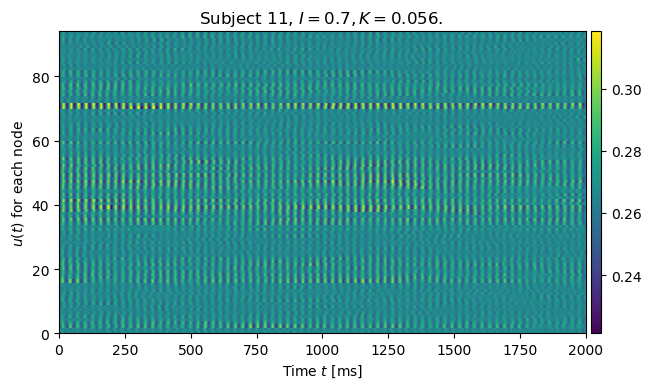

Subject 12: 1e-1 Accuracy found! 0.1
Subject 12: 1e-2 Accuracy found! 0.060000000000000005
Subject 12: 1e-3 Accuracy found! 0.05800000000000001
Subject 12: 1e-1 Accuracy found! 0.1
Subject 12: 1e-2 Accuracy found! 0.060000000000000005
Subject 12: 1e-3 Accuracy found! 0.05700000000000001
Subject 12: 1e-1 Accuracy found! 0.1
Subject 12: 1e-2 Accuracy found! 0.060000000000000005
Subject 12: 1e-3 Accuracy found! 0.05800000000000001


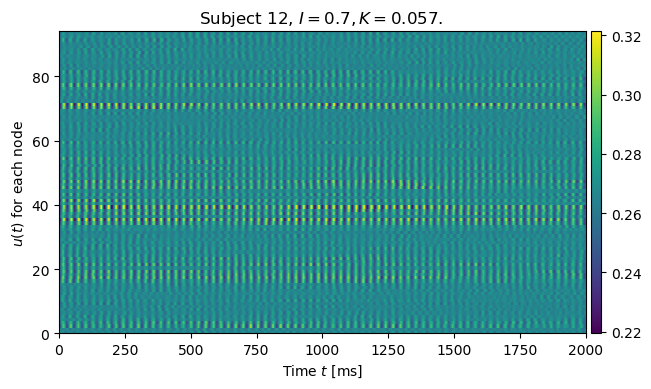

In [141]:
par = load_parameters()
par['sigma'] = 0.001
par['I'] = 0.7
KsI07 = []
KsI07_seed1 = []
KsI07_seed2 = []
for i, SC in enumerate(SCs):
    par['SC'] = SC
    par['K'] = 0.
    K_I07 = find_k_transition(par,i+1, thres=0.08)
    K_I07_seed1 = find_k_transition(par,i+1,rs=1, thres=0.08)
    K_I07_seed2 = find_k_transition(par,i+1,rs=2, thres=0.08)
    par['K'] = K_I07
    _,xs,_,_,_,_ = timeIntegrationRK4(par, randomseed=42)
    plotSpikeTrain_ini(xs[:,10000:], par, 'Subject {}, '.format(i+1))
    KsI07.append(K_I07)
    KsI07_seed1.append(K_I07_seed1)
    KsI07_seed2.append(K_I07_seed2)


Text(0.5, 1.0, 'Transistions for $I_{ext}=0.7$')

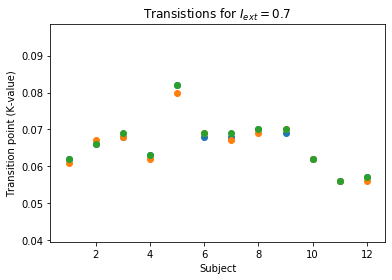

In [143]:
plt.scatter([x+1 for x in range(12)], KsI07)
plt.scatter([x+1 for x in range(12)], KsI07_seed1)
plt.scatter([x+1 for x in range(12)], KsI07_seed2)
plt.xlabel('Subject')
plt.ylabel('Transition point (K-value)')
plt.title(r'Transistions for $I_{ext}=0.7$')